In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
from scipy.signal import detrend
import pandas as pd
from datetime import datetime
from eofs.xarray import Eof

In [2]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38563 instead
  warnings.warn(


In [102]:
#load observational SST
hadsst = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_sst.nc", chunks = {'time':12}).sst
hadsst = hadsst.sortby(hadsst.latitude, ascending=True)
#rename coords
#hadsst = hadsst.rename({"lon": "longitude", "lat": "latitude"})
hadsst =hadsst.sel(time = slice("1850-01-01", "2022-12-31"))
hadsst = hadsst.compute()

In [103]:
hadsst1 = xr.where(hadsst == -1000, np.nan, hadsst)

In [100]:
de_had = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/detrend_hadisst_1x1.nc", chunks = {'time':12}).__xarray_dataarray_variable__

In [7]:
oisst = xr.open_dataset("/g/data/e14/sm2435/CMIP6_bias_project/NOAA_OISSTv2.nc").sst

In [8]:
ersstv5 = xr.open_dataset("/g/data/e14/sm2435/ersstv5.nc").sst

In [9]:
ersstv5 =ersstv5.sel(time = slice("1950-01-01", "2019-12-31"))

In [10]:
oisst = oisst.rename({"lon": "longitude", "lat": "latitude"})
ersstv5 = ersstv5.rename({"lon": "longitude", "lat": "latitude"})

In [11]:
ersstv5 = ersstv5.sortby(ersstv5.latitude, ascending=True)
ersstv5 = ersstv5.compute()

In [12]:
def roll_lon(df):
    df.coords['longitude'] = (df.coords['longitude'] + 360) % 360# - 180
    df = df.sortby(df.longitude)
    return df

In [13]:
oisst = roll_lon(oisst)

In [104]:
hadsst1 = roll_lon(hadsst1)

In [15]:
de_had = roll_lon(de_had)
de_had = de_had.compute()

In [105]:
def ssta(DS):
    clim = DS.sel(time = slice("1990-01-01", "2005-12-31")).groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def NINO34_sst(DS):
    return (DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
def NINO3(DS):
    return ssta(DS).sel(latitude=slice(
         -5, 5),longitude=slice(210, 270)).mean(['latitude', 'longitude'])
def NINO34(DS):
    return ssta(DS).sel(latitude=slice(
         -5, 5),longitude=slice(190, 240)).mean(['latitude', 'longitude'])
def NINO4(DS):
    return ssta(DS).sel(latitude=slice(
         -5, 5),longitude=slice(160, 210)).mean(['latitude', 'longitude'])
def DMI(DS):
    WTIO =  ssta(DS).sel(latitude=slice(
         -10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO =  ssta(DS).sel(latitude=slice(
         -10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return (WTIO - SETIO)

In [18]:
def ENLN_events(ds, fn):
    """
    Identifies El Niño (EN) and La Niña (LN) events based on the Nino3.4 index timeseries within specific seasons.

    Parameters:
    ds (xarray.Dataset): Input dataset containing the Nino3.4 index values.

    Returns:
    tuple: Two DataArrays representing El Niño (EN) and La Niña (LN) events.
    """
    # Get the Nino34 timeseries in seasons starting from DJF, MAM, etc.
    QS = fn(ds).resample(time='QS-DEC').mean(dim="time")
    
    # Select DJF seasons into a timeseries
    DJF = QS.groupby('time.season')["DJF"]
    
    # Use quantiles to select all events and create DataArrays of EN and LN event values
    TH = DJF.std()
    LN = DJF.where(DJF <= -TH).dropna(dim="time")
    EN = DJF.where(DJF > TH.values).dropna(dim="time")
    
    return LN, EN

def get_ENLN_times(fn, ds_sst, ds_var=None):
    """
    Subsets a variable based on the positive (EN) and negative (LN) El Niño/La Niña events derived from Sea Surface Temperature (SST) dataset.

    Parameters:
    ds_sst (xarray.Dataset): Sea Surface Temperature dataset containing Nino3.4 index events.
    ds_var (xarray.Dataset, optional): Variable dataset to be subset based on ENLN events. Defaults to None.

    Returns:
    tuple: Two subsets of the variable dataset corresponding to positive (subset_ds_pos) and negative (subset_ds_neg) ENLN events.
    """
    # Extract positive (EN) and negative (LN) ENLN events based on SST dataset
    LN, EN = ENLN_events(ds_sst, fn)
    
    # Calculate the mean year for LN and EN
    LN = LN.groupby("time.year").mean("time").year
    EN = EN.groupby("time.year").mean("time").year
    
    # If ds_var is not provided, use ds_sst
    if ds_var is None:
        ds_var = ds_sst
    
        
    # Initialize empty lists to store subsets
    pos_list = []
    pos_list2 = []
    neg_list = []
    neg_list2 = []
    
    # Loop through each year group in ds_var and subset based on specific years in LN and EN
    for year, group in ds_var.groupby("time.year"):
        try:
            if year in EN:
                pos_subset = group
                pos_list.append(pos_subset)
                pos_list2.append(ds_var.groupby("time.year")[year+1])
            elif year in LN:
                neg_subset = group
                neg_list.append(neg_subset)
                neg_list2.append(ds_var.groupby("time.year")[year+1])
            else:
                pass
        except:
            print("some error, probs year is no in timeseries")
    
    # Concatenate subsets into a single DataArray
    subset_ds_pos = xr.concat(pos_list, dim='time')
    subset_ds_pos2 = xr.concat(pos_list2, dim='time')
    
    subset_ds_neg = xr.concat(neg_list, dim='time')
    subset_ds_neg2 = xr.concat(neg_list2, dim='time')
    
    return subset_ds_pos,subset_ds_pos2, subset_ds_neg, subset_ds_neg2

In [19]:
def monthly_evo(TS1, TS2):
    TS1m = TS1.groupby("time.month").mean("time")
    TS2m = TS2.groupby("time.month").mean("time").assign_coords({"month":[13,14,15,16,17,18,19,20,21,22,23,24]})
    TS3 = xr.concat([TS1m, TS2m], dim = "month")
    return TS3

In [20]:
def Modoki(DS):
    boxa = ssta(DS).sel(latitude=slice(
        -10, 10),longitude=slice(165, 220)).mean(['latitude', 'longitude'])
    boxb = ssta(DS).sel(latitude=slice(
        -15, 5),longitude=slice(250, 290)).mean(['latitude', 'longitude'])
    boxc = ssta(DS).sel(latitude=slice(
        -10, 20),longitude=slice(125, 145)).mean(['latitude', 'longitude'])
    return (boxa - (0.5*boxb) - (0.5*boxc))

In [21]:
def EP_CP_index(DS):
    sst_anom = ssta(DS)
    sst_anom = sst_anom.sel(longitude = slice(140, 280), latitude = slice(-15,15))
    coslat = np.cos(np.deg2rad(sst_anom.coords['latitude'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(sst_anom, weights=wgts)
    pc1 = solver.pcs(npcs=2, pcscaling=1)
    EP = (pc1[:,0]+pc1[:,1])/np.sqrt(2)
    CP = (pc1[:,0]-pc1[:,1])/np.sqrt(2)
    return EP,CP

In [90]:
def EP_CP_PCS(DS):
    sst_anom = ssta(DS)
    sst_anom = sst_anom.sel(longitude = slice(140, 280), latitude = slice(-15,15))
    coslat = np.cos(np.deg2rad(sst_anom.coords['latitude'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(sst_anom, weights=wgts)
    pc1 = solver.pcs(npcs=2, pcscaling=1)
    return pc1

In [22]:
def EP_CP_eof(DS):
    sst_anom = ssta(DS)
    sst_anom = sst_anom.sel(longitude = slice(140, 280), latitude = slice(-15,15))
    coslat = np.cos(np.deg2rad(sst_anom.coords['latitude'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(sst_anom, weights=wgts)
    eofs_ = solver.eofsAsCovariance(neofs=4)
    return eofs_

In [23]:
def EP_CP_VF(DS):
    sst_anom = ssta(DS)
    sst_anom = sst_anom.sel(longitude = slice(140, 280), latitude = slice(-15,15))
    coslat = np.cos(np.deg2rad(sst_anom.coords['latitude'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(sst_anom, weights=wgts)
    VF = solver.varianceFraction(4)
    return VF


In [24]:
def event_djf(ts,season):
    QS = ts.resample(time='QS-DEC').mean(dim="time")
    # Select DJF seasons into a timeseries
    DJF = QS.groupby('time.season')[season]
    # Use quantiles to select all events and create DataArrays of EN and LN event values
    TH = QS.std()
    LN = DJF.where(DJF <= -TH).dropna(dim="time")
    EN = DJF.where(DJF > TH.values).dropna(dim="time")
    return EN, LN

In [25]:
def EPCP_events(ds):
   
    # Get the Nino34 timeseries in seasons starting from DJF, MAM, etc.
    EP, CP = EP_CP_index(ds)
    EP_E, EP_L = event_djf(EP, "DJF")
    CP_E, CP_L = event_djf(CP, "DJF")
    
    return EP_E, EP_L, CP_E, CP_L

In [26]:
def monthly_evo(TS1, TS2):
    TS1m = TS1.groupby("time.month").mean("time")
    TS2m = TS2.groupby("time.month").mean("time").assign_coords({"month":[13,14,15,16,17,18,19,20,21,22,23,24]})
    TS3 = xr.concat([TS1m, TS2m], dim = "month")
    JJA = TS3.sel(month = slice(6,8)).mean("month").expand_dims({"season":["JJA(0)"]})
    SON = TS3.sel(month = slice(9,11)).mean("month").expand_dims({"season":["SON(0)"]})
    DJF = TS3.sel(month = slice(12,14)).mean("month").expand_dims({"season":["D(0)JF(1)"]})
    MAM = TS3.sel(month = slice(15,17)).mean("month").expand_dims({"season":["MAM(1)"]})
    TS4 = xr.concat([JJA,SON,DJF,MAM], dim = "season")
    
    return TS4

In [27]:
def get_EPCP_times(ds_sst, ds_var=None):

    EP_E, EP_L, CP_E, CP_L = EPCP_events(ds_sst)
    
    # Calculate the mean year for LN and EN
    EP_E = EP_E.groupby("time.year").mean("time").year
    EP_L = EP_L.groupby("time.year").mean("time").year
    CP_E = CP_E.groupby("time.year").mean("time").year
    CP_L = CP_L.groupby("time.year").mean("time").year
    
    # If ds_var is not provided, use ds_sst
    if ds_var is None:
        ds_var = ssta(ds_sst)
    
        
    # Initialize empty lists to store subsets
    epos_list = []
    epos_list2 = []
    eneg_list = []
    eneg_list2 = []
    
    # Loop through each year group in ds_var and subset based on specific years in LN and EN
    for year, group in ds_var.groupby("time.year"):
        try:
            if year in EP_E:
                pos_subset = group
                epos_list.append(pos_subset)
                epos_list2.append(ds_var.groupby("time.year")[year+1])
            elif year in EP_L:
                neg_subset = group
                eneg_list.append(neg_subset)
                eneg_list2.append(ds_var.groupby("time.year")[year+1])
            else:
                pass
        except:
            print("some error, probs year is no in timeseries", year)
    
    # Concatenate subsets into a single DataArray
    esubset_ds_pos = xr.concat(epos_list, dim='time')
    esubset_ds_pos2 = xr.concat(epos_list2, dim='time')
    
    esubset_ds_neg = xr.concat(eneg_list, dim='time')
    esubset_ds_neg2 = xr.concat(eneg_list2, dim='time')
    
     # Initialize empty lists to store subsets
    cpos_list = []
    cpos_list2 = []
    cneg_list = []
    cneg_list2 = []
    
    # Loop through each year group in ds_var and subset based on specific years in LN and EN
    for year, group in ds_var.groupby("time.year"):
        try:
            if year in CP_E:
                pos_subset = group
                cpos_list.append(pos_subset)
                cpos_list2.append(ds_var.groupby("time.year")[year+1])
            elif year in CP_L:
                neg_subset = group
                cneg_list.append(neg_subset)
                cneg_list2.append(ds_var.groupby("time.year")[year+1])
            else:
                pass
        except:
            print("some error, probs year is no in timeseries", year)
    
    # Concatenate subsets into a single DataArray
    csubset_ds_pos = xr.concat(cpos_list, dim='time')
    csubset_ds_pos2 = xr.concat(cpos_list2, dim='time')
    
    csubset_ds_neg = xr.concat(cneg_list, dim='time')
    csubset_ds_neg2 = xr.concat(cneg_list2, dim='time')
    #now convert these to means and composite evolutions
    EP_E12 = monthly_evo(esubset_ds_pos, esubset_ds_pos2)
    EP_L12 = monthly_evo(esubset_ds_neg, esubset_ds_neg2)

    CP_E12 = monthly_evo(csubset_ds_pos, csubset_ds_pos2)
    CP_L12 = monthly_evo(csubset_ds_neg, csubset_ds_neg2)

    
    return EP_E12, EP_L12, CP_E12, CP_L12

In [106]:
EP_E, EP_L, CP_E, CP_L = EPCP_events(hadsst1)


In [107]:
CP_L

<xarray.DataArray 'pcs' (time: 19)>
array([-1.1524363 , -1.0860243 , -1.1714348 , -1.4709786 , -0.97727394,
       -1.3206764 , -1.1705788 , -1.5252143 , -1.037837  , -1.2918142 ,
       -1.2169423 , -0.97230697, -1.1468766 , -1.0095915 , -0.98036623,
       -1.9639716 , -1.0444878 , -1.7844721 , -1.2126898 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1869-12-01 1873-12-01 ... 2022-12-01

In [108]:
EP_E12, EP_L12, CP_E12, CP_L12 = get_EPCP_times(hadsst1)

some error, probs year is no in timeseries 2022


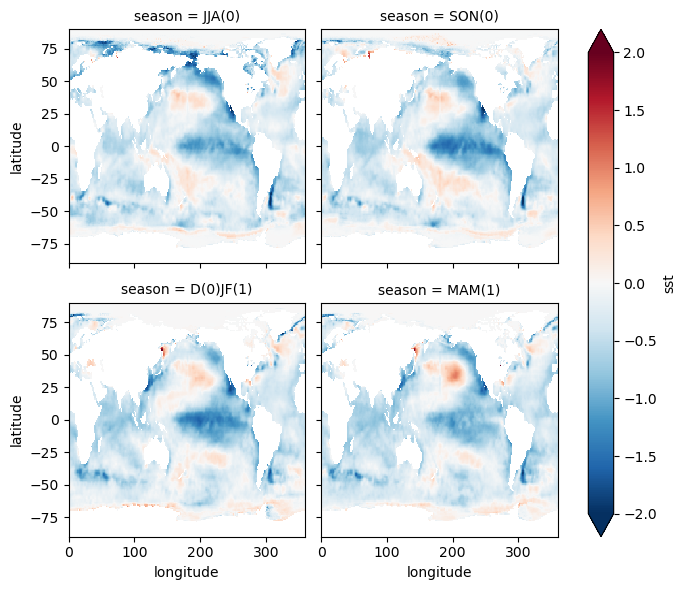

In [109]:
EP_L12.plot(col = "season", col_wrap =2, vmin = -2)

In [65]:
EPCP_events(hadsst1)

(<xarray.DataArray 'pcs' (time: 8)>
 array([1.0947262 , 1.7966719 , 1.0774344 , 3.8105304 , 0.97990483,
        1.281597  , 3.9148757 , 2.0096571 ], dtype=float32)
 Coordinates:
   * time     (time) datetime64[ns] 1965-12-01 1972-12-01 ... 2015-12-01,
 <xarray.DataArray 'pcs' (time: 4)>
 array([-1.0335   , -1.272921 , -1.5475941, -1.374013 ], dtype=float32)
 Coordinates:
   * time     (time) datetime64[ns] 1949-12-01 1967-12-01 2017-12-01 2021-12-01,
 <xarray.DataArray 'pcs' (time: 14)>
 array([1.1599416 , 1.5447702 , 1.0139924 , 1.3928814 , 1.1753439 ,
        0.98517114, 1.2303486 , 1.2179812 , 1.3098191 , 1.8830639 ,
        1.643478  , 2.0231125 , 1.1037785 , 1.6872681 ], dtype=float32)
 Coordinates:
   * time     (time) datetime64[ns] 1957-12-01 1968-12-01 ... 2019-12-01,
 <xarray.DataArray 'pcs' (time: 17)>
 array([-1.1204252, -1.4987882, -1.3410307, -1.796513 , -1.3601953,
        -1.8150932, -1.0346001, -2.4393268, -1.3297616, -2.6096878,
        -1.0086099, -1.949685 , -1.5619

In [66]:
EP_CP_VF(hadsst1)

<xarray.DataArray 'variance_fractions' (mode: 4)>
array([0.6042409 , 0.12670472, 0.06919541, 0.03199827], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3
Attributes:
    long_name:  variance_fractions

In [34]:
eofs_ = EP_CP_eof(hadsst1)

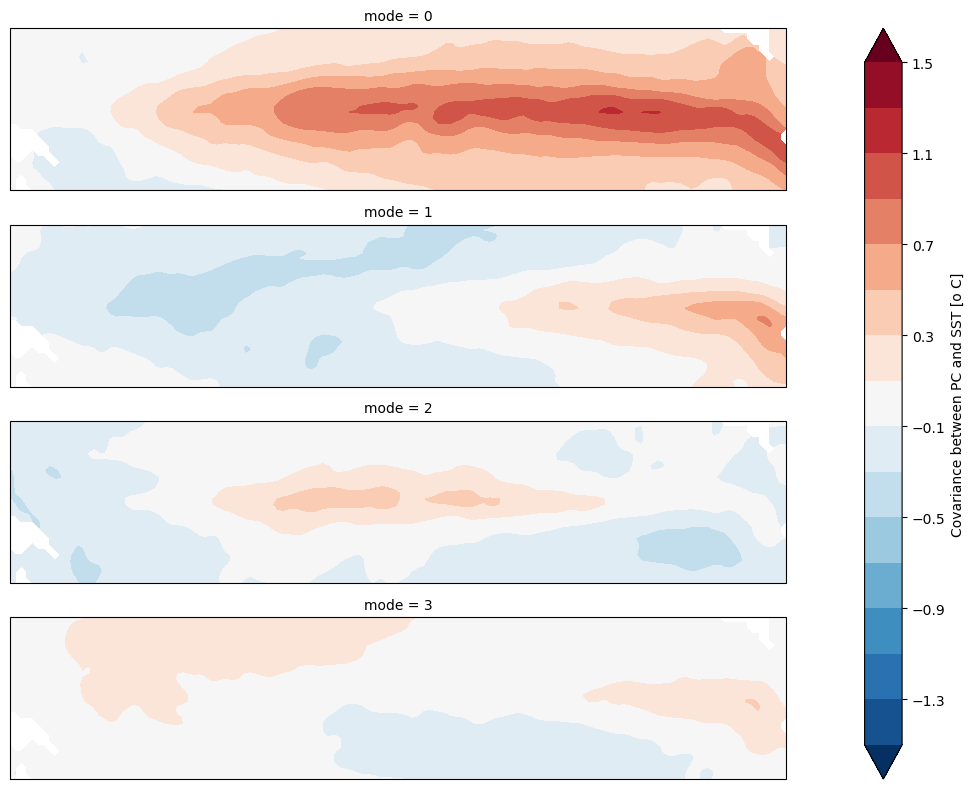

In [35]:
eofs_.plot.contourf(col = "mode", col_wrap = 1, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)},
                          figsize=(16,8), vmin = -1.5, levels =16
                    , extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='Covariance between PC and SST [o C]'))


In [67]:
EP, CP = EP_CP_index(hadsst1)

In [35]:
from scipy.stats import pearsonr

In [72]:
DJF_EP = EP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"].groupby('time.year').mean("time")[1:]
DJF_CP = CP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"].groupby('time.year').mean("time")[1:]
SON_DMI = DMI(hadsst1).resample(time='QS-DEC').mean(dim="time").groupby('time.season')["SON"].groupby('time.year').mean("time")

In [78]:
DJF_N3 = NINO3(hadsst1).resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"].groupby('time.year').mean("time")[1:]
DJF_mod = Modoki(hadsst1).resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"].groupby('time.year').mean("time")[1:]


In [75]:
pearsonr(DJF_EP, SON_DMI)

PearsonRResult(statistic=0.4029695875557198, pvalue=0.00040827272175814527)

In [76]:
pearsonr(DJF_CP, SON_DMI)

PearsonRResult(statistic=0.4313591359875889, pvalue=0.0001389155097601796)

In [77]:
pearsonr(DJF_N3, SON_DMI)

PearsonRResult(statistic=0.5413673874245563, pvalue=7.596529686041949e-07)

In [80]:
pearsonr(DJF_mod, DJF_CP)

PearsonRResult(statistic=0.7905093467341006, pvalue=9.023735429516148e-17)

In [81]:
pearsonr(DJF_N3, DJF_EP)

PearsonRResult(statistic=0.8391358219778559, pvalue=1.8688761951194705e-20)

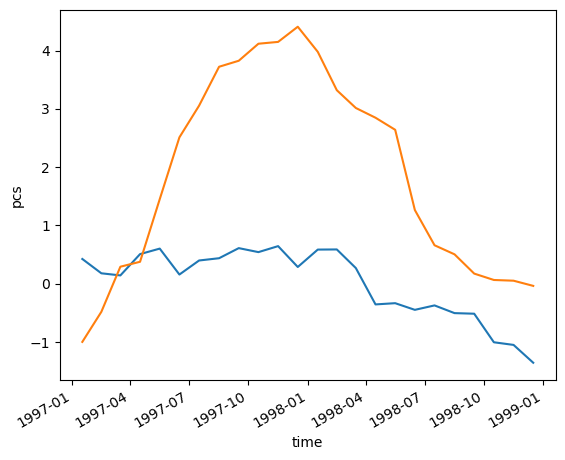

In [39]:
CP.sel(time = slice('1997-01-01', '1998-12-31')).plot()
EP.sel(time = slice('1997-01-01', '1998-12-31')).plot()

Text(0.5, 1.0, 'HadISST EP and CP indexes (season averaged each year)')

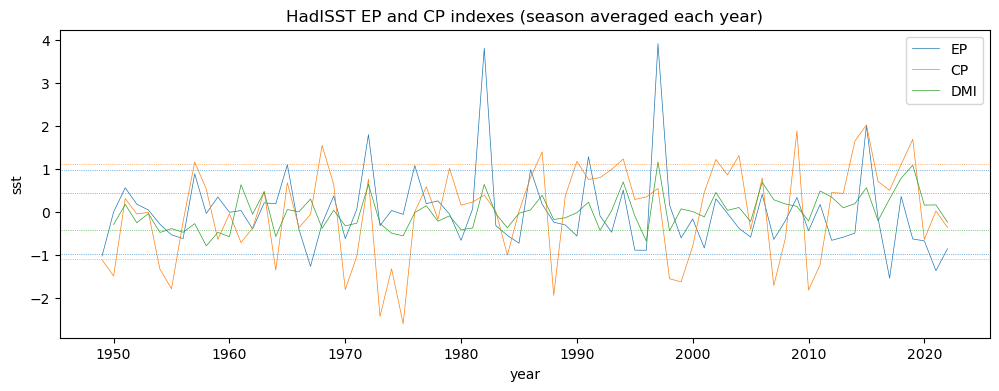

In [85]:
EP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')['DJF'].groupby('time.year').mean('time').plot(figsize = (12, 4),  lw= 0.5, label = "EP")
CP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')['DJF'].groupby('time.year').mean('time').plot(lw= 0.5, label = "CP")
DMI(hadsst1).resample(time='QS-DEC').mean(dim="time").groupby('time.season')['SON'].groupby('time.year').mean('time').plot(lw= 0.5, label = "DMI")

plt.axhline(CP.groupby("time.season")["DJF"].std(), c = 'tab:orange', lw = 0.5, ls = ":")
plt.axhline(-1*CP.groupby("time.season")["DJF"].std(), c = 'tab:orange', lw = 0.5, ls = ":")
plt.axhline(EP.groupby("time.season")["DJF"].std(), c = 'tab:blue', lw = 0.5, ls = ":")
plt.axhline(-1*EP.groupby("time.season")["DJF"].std(), c = 'tab:blue', lw = 0.5, ls = ":")
plt.axhline(DMI(hadsst1).groupby("time.season")["SON"].std(), c = 'tab:green', lw = 0.5, ls = ":")
plt.axhline(-1*DMI(hadsst1).groupby("time.season")["SON"].std(), c = 'tab:green', lw = 0.5, ls = ":")

plt.legend()
plt.title("HadISST EP and CP indexes (season averaged each year)")

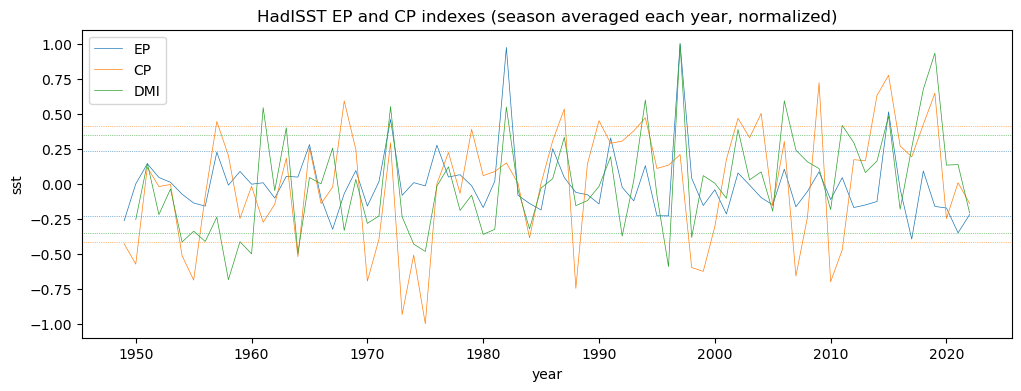

In [86]:
# Perform groupby and aggregation
EP_aggregated = EP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')['DJF'].groupby('time.year').mean('time')
CP_aggregated = CP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')['DJF'].groupby('time.year').mean('time')
DMI_aggregated = DMI(hadsst1).resample(time='QS-DEC').mean(dim="time").groupby('time.season')['SON'].groupby('time.year').mean('time')

# Calculate maximum values for normalization
max_EP = abs(EP_aggregated).max()
max_CP = abs(CP_aggregated).max()
max_DMI = abs(DMI_aggregated).max()

# Normalize and plot
(EP_aggregated / max_EP).plot(figsize=(12, 4), lw=0.5, label="EP")
(CP_aggregated / max_CP).plot(lw=0.5, label="CP")
(DMI_aggregated / max_DMI).plot(lw=0.5, label="DMI")

# Standard deviation lines (normalized)
plt.axhline((CP_aggregated / max_CP).std(), c='tab:orange', lw=0.5, ls=":")
plt.axhline(-1*(CP_aggregated / max_CP).std(), c='tab:orange', lw=0.5, ls=":")
plt.axhline((EP_aggregated / max_EP).std(), c='tab:blue', lw=0.5, ls=":")
plt.axhline(-1*(EP_aggregated / max_EP).std(), c='tab:blue', lw=0.5, ls=":")
plt.axhline((DMI_aggregated / max_DMI).std(), c='tab:green', lw=0.5, ls=":")
plt.axhline(-1*(DMI_aggregated / max_DMI).std(), c='tab:green', lw=0.5, ls=":")

plt.legend()
plt.title("HadISST EP and CP indexes (season averaged each year, normalized)")
plt.show()

In [110]:
pcs = EP_CP_PCS(hadsst1)

In [94]:
pcs_djf = pcs.resample(time='QS-DEC').mean(dim="time").groupby('time.season')['DJF'].groupby('time.year').mean('time')

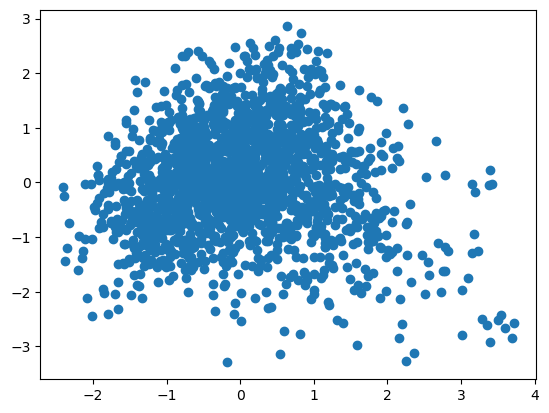

In [112]:
plt.scatter(pcs[:,0].values, pcs[:,1].values)

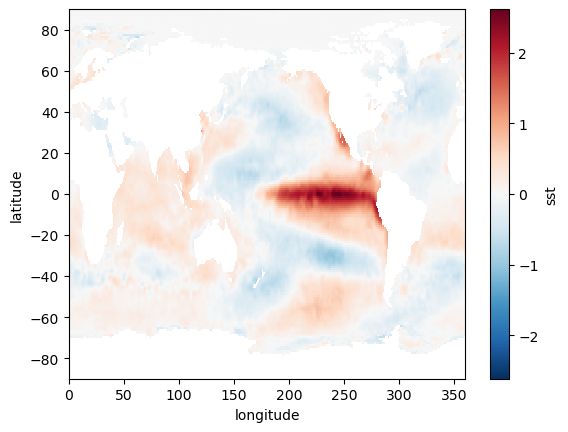

In [49]:
ssta(hadsst1).resample(time='QS-DEC').mean(dim="time").where(EP_E).mean("time").plot()

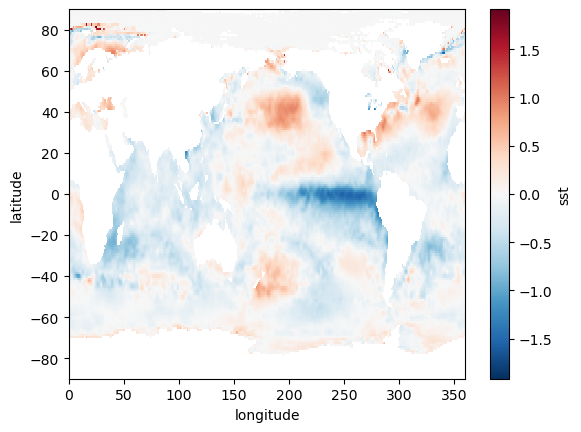

In [50]:
ssta(hadsst1).resample(time='QS-DEC').mean(dim="time").where(EP_L).mean("time").plot()

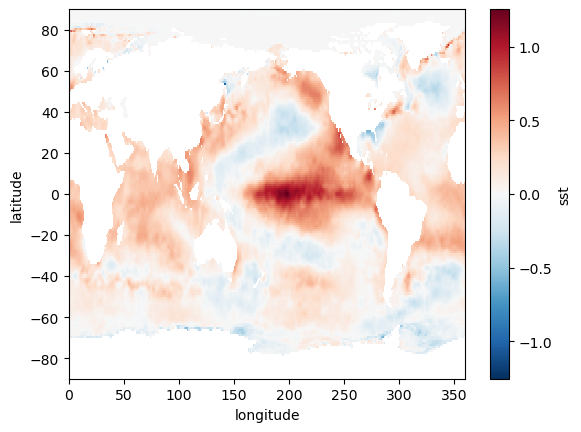

In [51]:
ssta(hadsst1).resample(time='QS-DEC').mean(dim="time").where(CP_E).mean("time").plot()

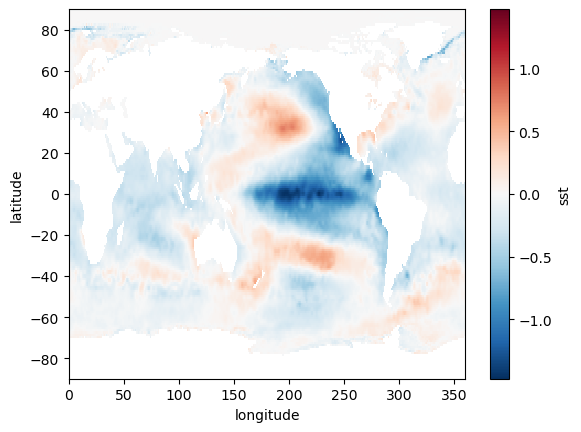

In [52]:
ssta(hadsst1).resample(time='QS-DEC').mean(dim="time").where(CP_L).mean("time").plot()

In [18]:
de_had_anom = de_had.groupby("time.month") - de_had.sel(
    time = slice("1990-01-01", "2020-12-31")).groupby("time.month").mean("time")

In [19]:
had_anom = hadsst1.groupby("time.month") - hadsst1.sel(
    time = slice("1990-01-01", "2020-12-31")).groupby("time.month").mean("time")

In [21]:
oi_anom = oisst.groupby("time.month") - oisst.sel(
    time = slice("1990-01-01", "2020-12-31")).groupby("time.month").mean("time")

In [22]:
er_anom = ersstv5.groupby("time.month") - ersstv5.sel(
    time = slice("1990-01-01", "2020-12-31")).groupby("time.month").mean("time")

In [23]:
#print the years of different events

In [39]:
L, E = ENLN_events(hadsst1, Modoki)

In [40]:
L.groupby("time.year").mean("time").year.values

array([1973, 1975, 1983, 1988, 1997, 1998, 1999, 2000, 2007, 2008, 2010,
       2011])

In [41]:
E.groupby("time.year").mean("time").year.values

array([1957, 1958, 1965, 1967, 1968, 1977, 1990, 1991, 1994, 2004, 2009,
       2014])

In [32]:
EN31, EN32, LN31, LN32 = get_ENLN_times(NINO3, hadsst1, had_anom)

In [28]:
EN31e, EN32e, LN31e, LN32e = get_ENLN_times(NINO3, ersstv5, er_anom)

In [29]:
EN31o, EN32o, LN31o, LN32o = get_ENLN_times(NINO3, oisst, oi_anom)

In [30]:
#now get the evolution of these timeseries and see what happens

In [31]:
def monthly_evo(TS1, TS2):
    TS1m = TS1.groupby("time.month").mean("time")
    TS2m = TS2.groupby("time.month").mean("time").assign_coords({"month":[13,14,15,16,17,18,19,20,21,22,23,24]})
    TS3 = xr.concat([TS1m, TS2m], dim = "month")
    JJA = TS3.sel(month = slice(6,8)).mean("month").expand_dims({"season":["JJA(0)"]})
    SON = TS3.sel(month = slice(9,11)).mean("month").expand_dims({"season":["SON(0)"]})
    DJF = TS3.sel(month = slice(12,14)).mean("month").expand_dims({"season":["D(0)JF(1)"]})
    MAM = TS3.sel(month = slice(15,17)).mean("month").expand_dims({"season":["MAM(1)"]})
    TS4 = xr.concat([JJA,SON,DJF,MAM], dim = "season")
    
    return TS4

In [76]:
EN3 = monthly_evo(EN31, EN32)
LN3 = monthly_evo(LN31, LN32)

In [55]:
boxa = ssta(hadsst1).sel(latitude=slice(
        -10, 10),longitude=slice(165, 220)).mean(['latitude', 'longitude']).sel(time = slice('1990-01-01', '2000-12-31'))
boxb = ssta(hadsst1).sel(latitude=slice(
        -15, 5),longitude=slice(250, 290)).mean(['latitude', 'longitude']).sel(time = slice('1990-01-01', '2000-12-31'))
boxc = ssta(hadsst1).sel(latitude=slice(
        -10, 20),longitude=slice(125, 145)).mean(['latitude', 'longitude']).sel(time = slice('1990-01-01', '2000-12-31'))


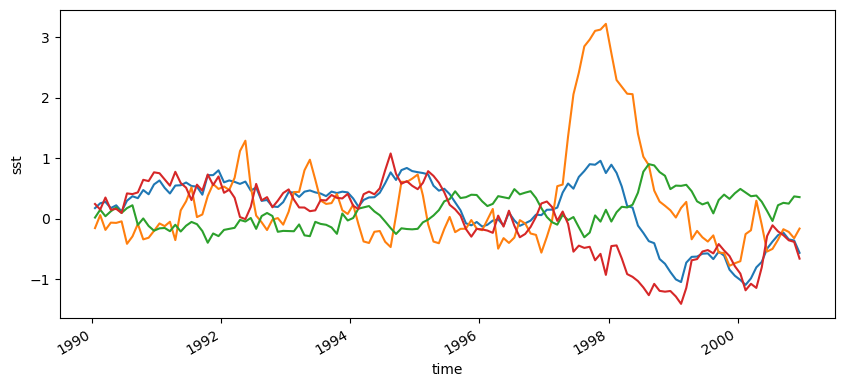

In [58]:
plt.figure(figsize = (10,4))
boxa.plot()
boxb.plot()
boxc.plot()
(boxa-(0.5*(boxb+boxc))).plot()

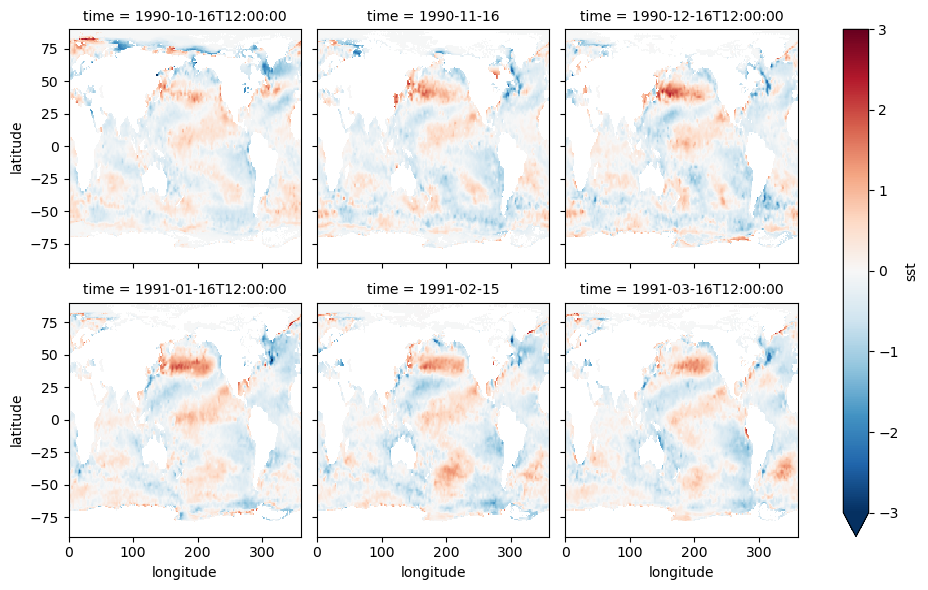

In [66]:
had_anom.sel(time = slice('1990-10-01', '1991-3-30')).plot(col = "time", col_wrap = 3, vmin = -3)

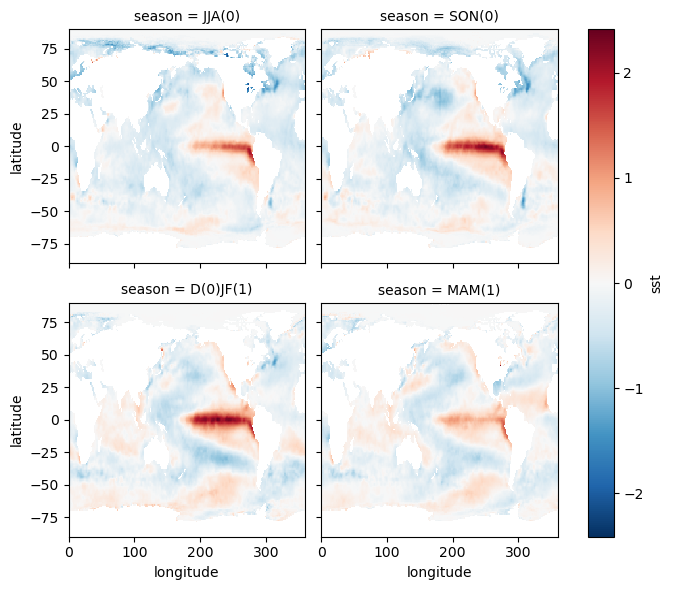

In [77]:
EN3.plot(col= "season", col_wrap = 2)

In [44]:
EN3o = monthly_evo(EN31o, EN32o)
LN3o = monthly_evo(LN31o, LN32o)

In [45]:
EN3e = monthly_evo(EN31e, EN32e)
LN3e = monthly_evo(LN31e, LN32e)

In [46]:
lat_limits = (-40, 40)
lon_limits = (-150, 120) 

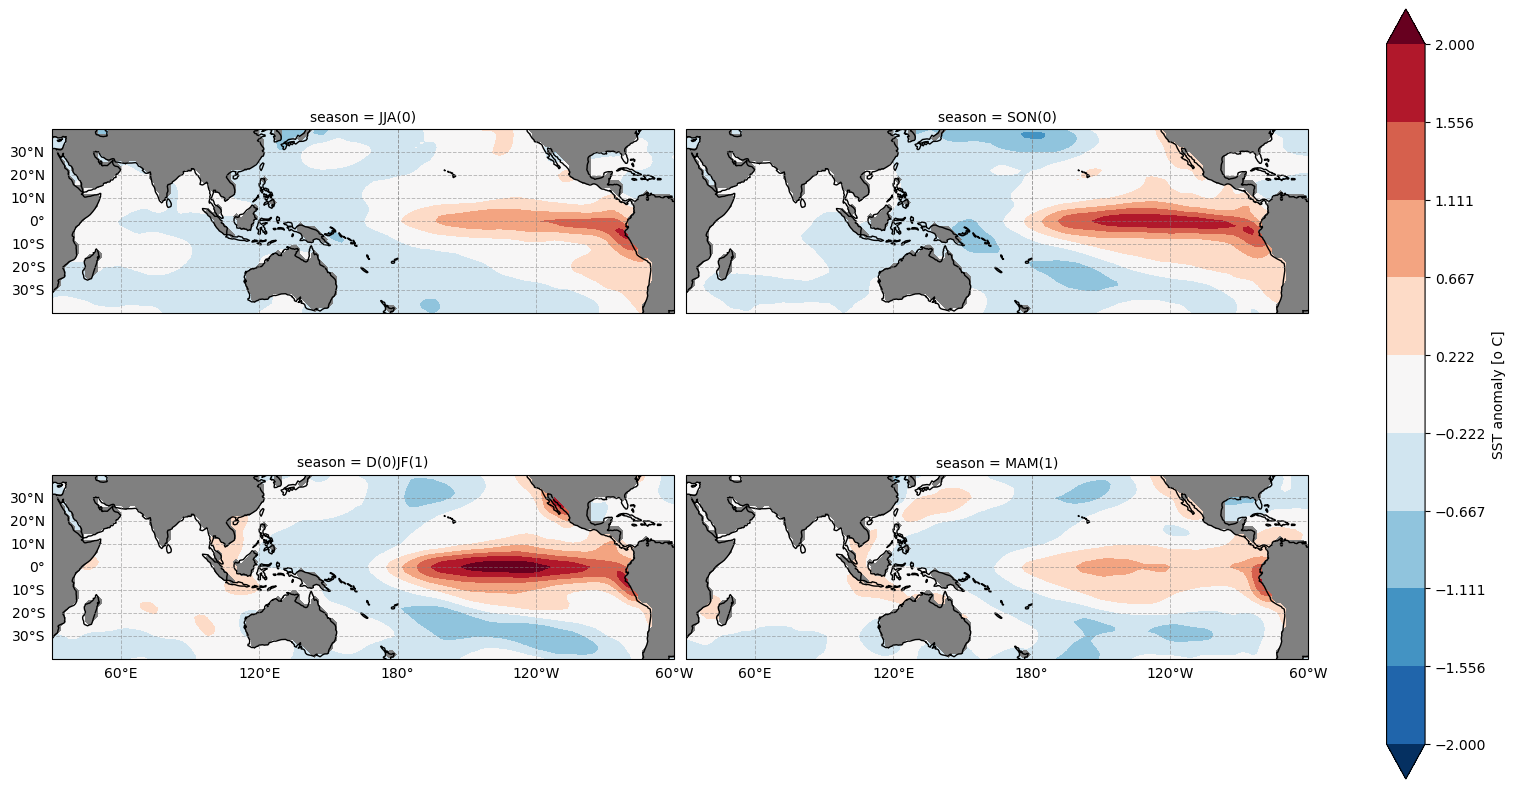

In [48]:
fg = EN3e.plot.contourf(col="season", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

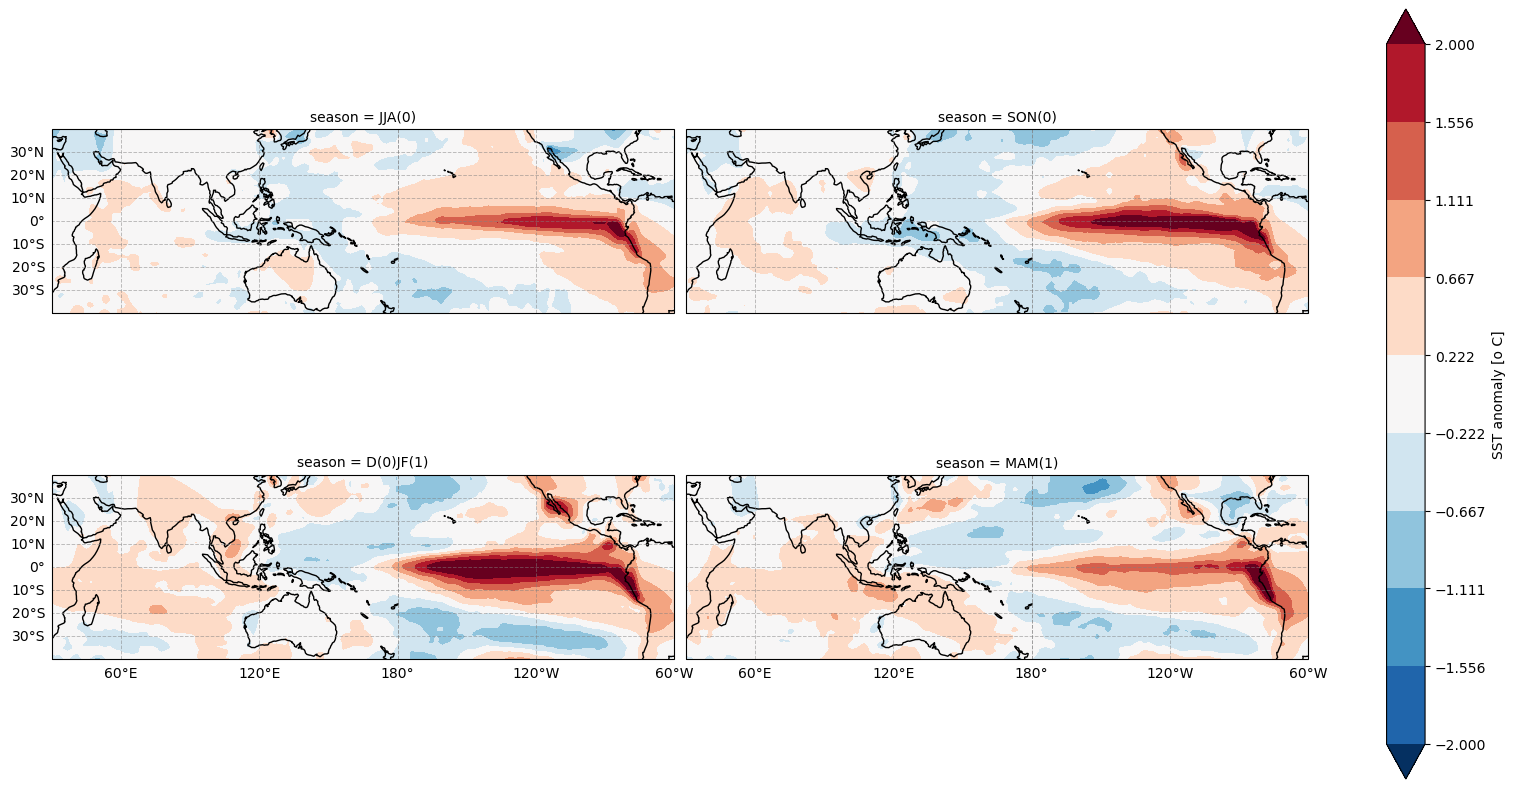

In [49]:
fg = EN3o.plot.contourf(col="season", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

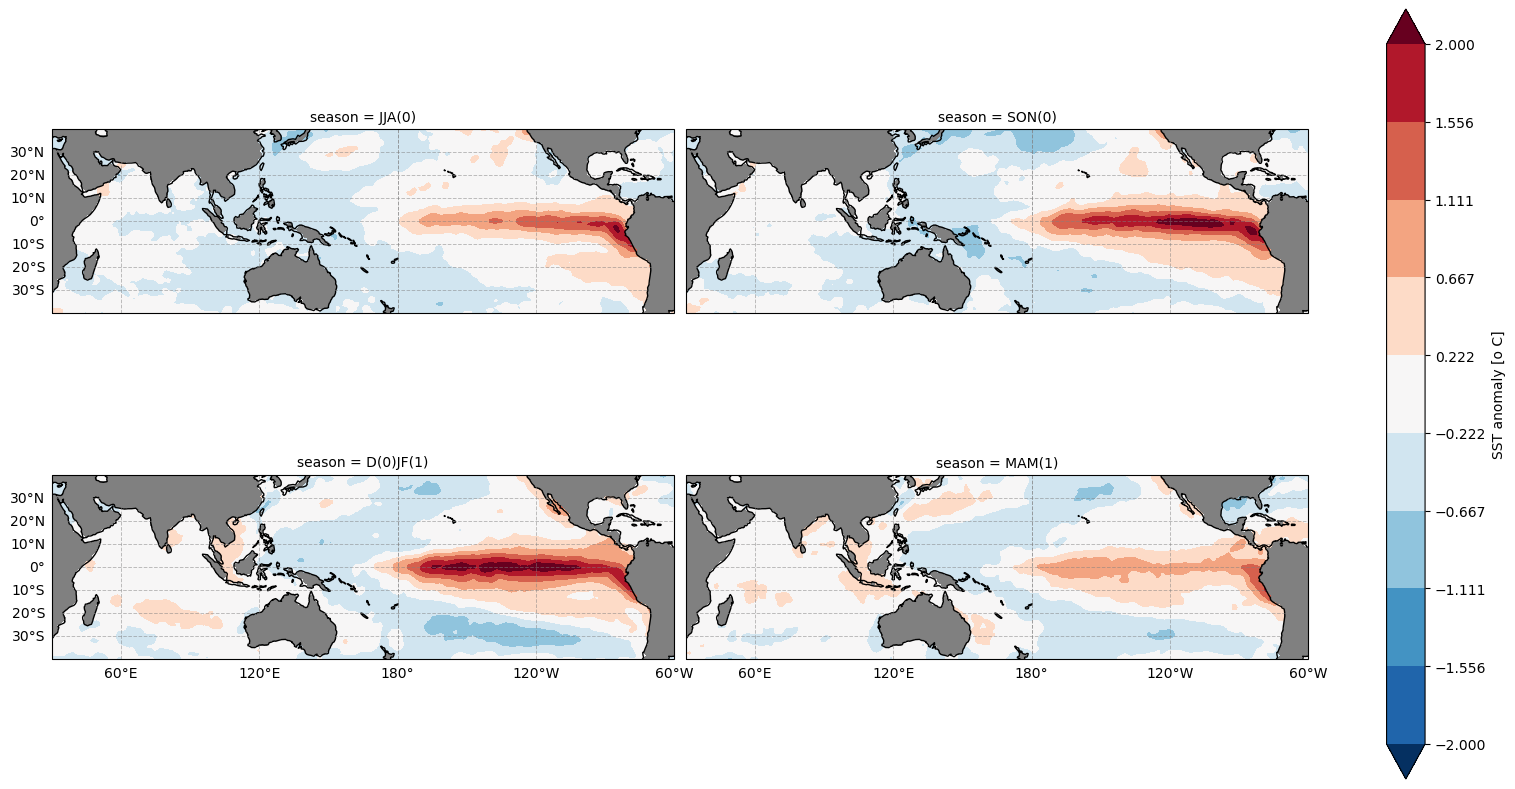

In [78]:
fg = EN3.plot.contourf(col="season", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

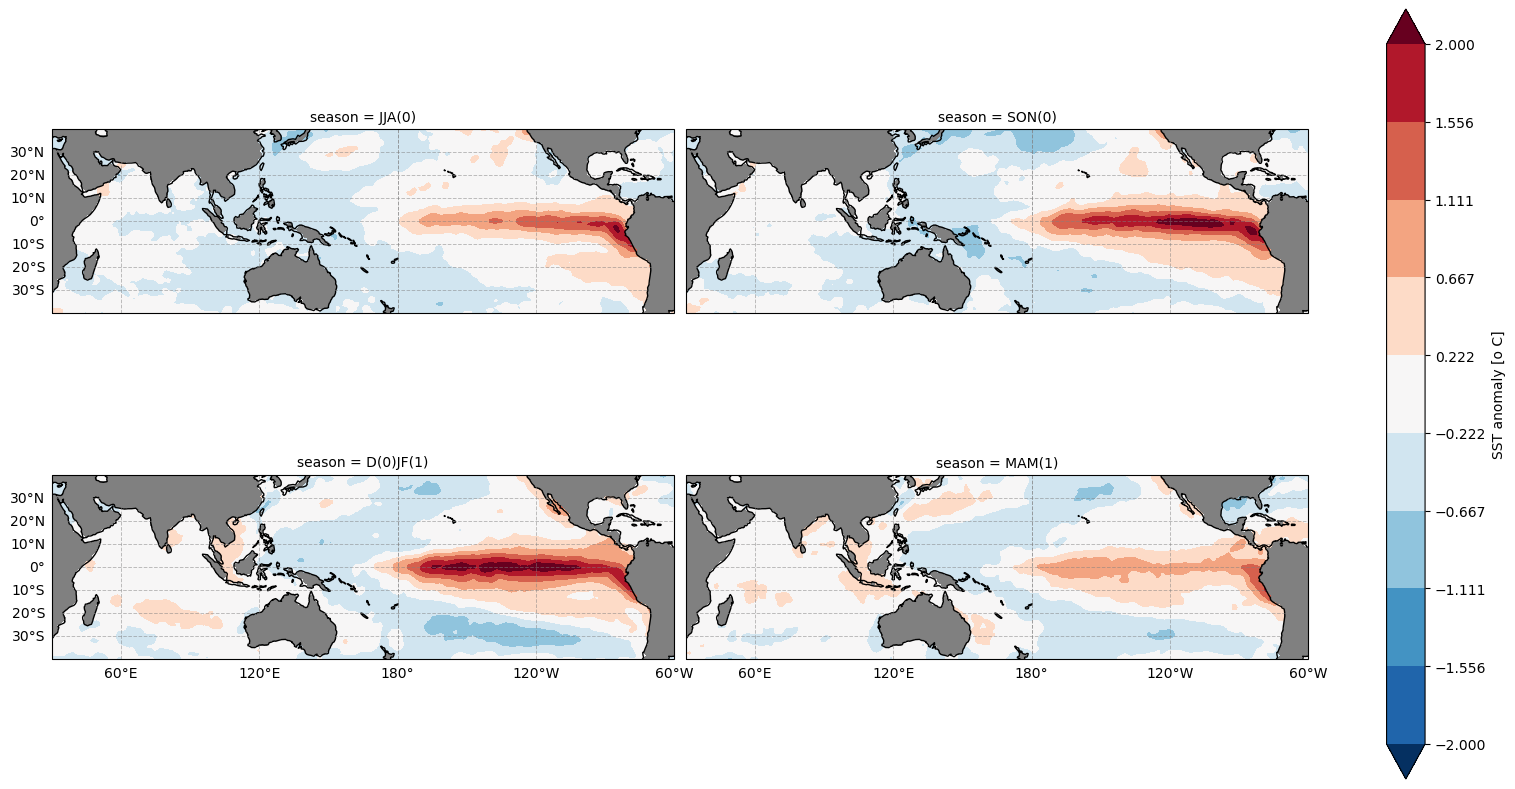

In [50]:
fg = EN3.plot.contourf(col="season", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

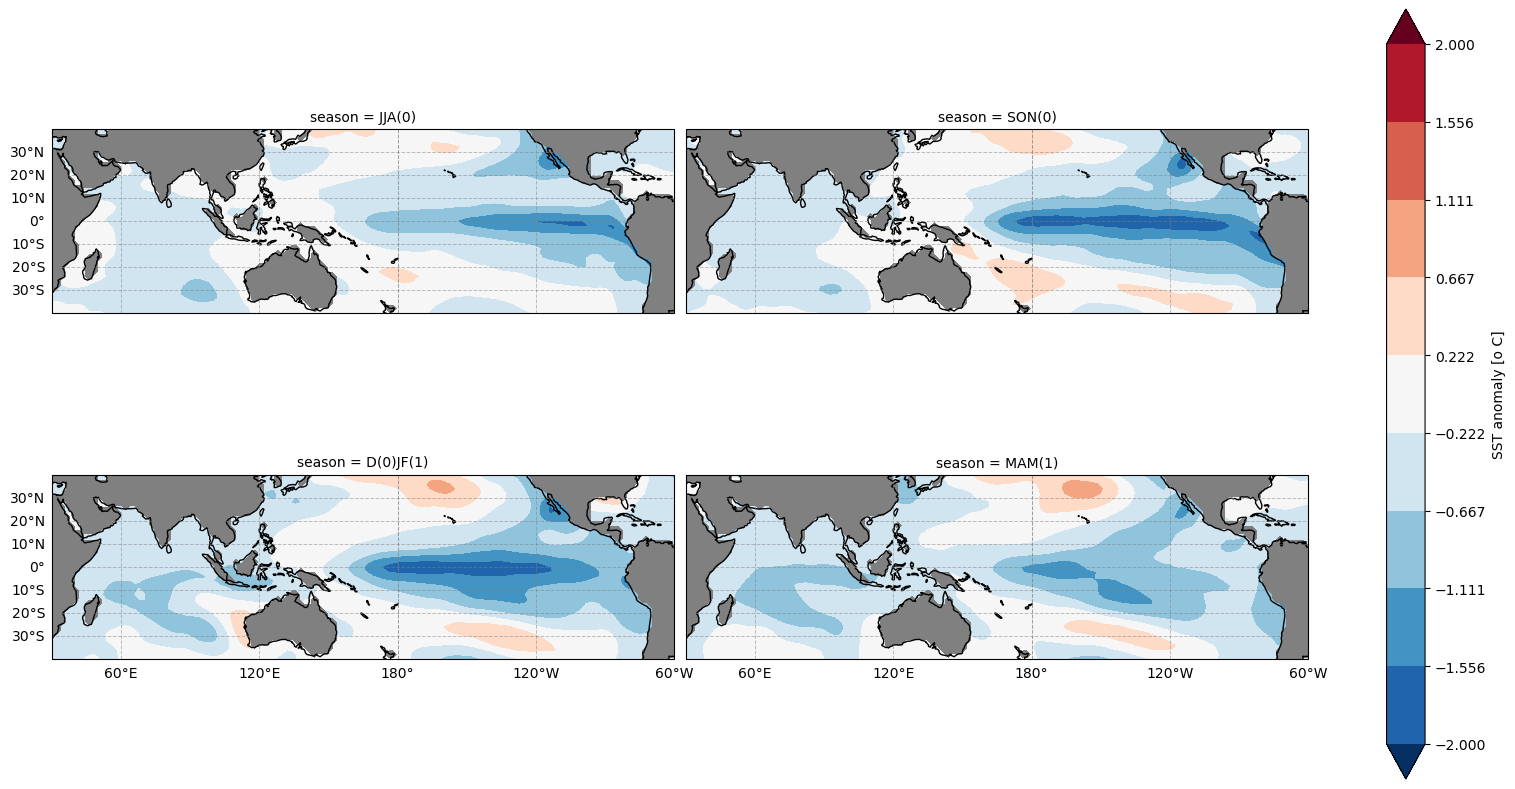

In [51]:
fg = LN3e.plot.contourf(col="season", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

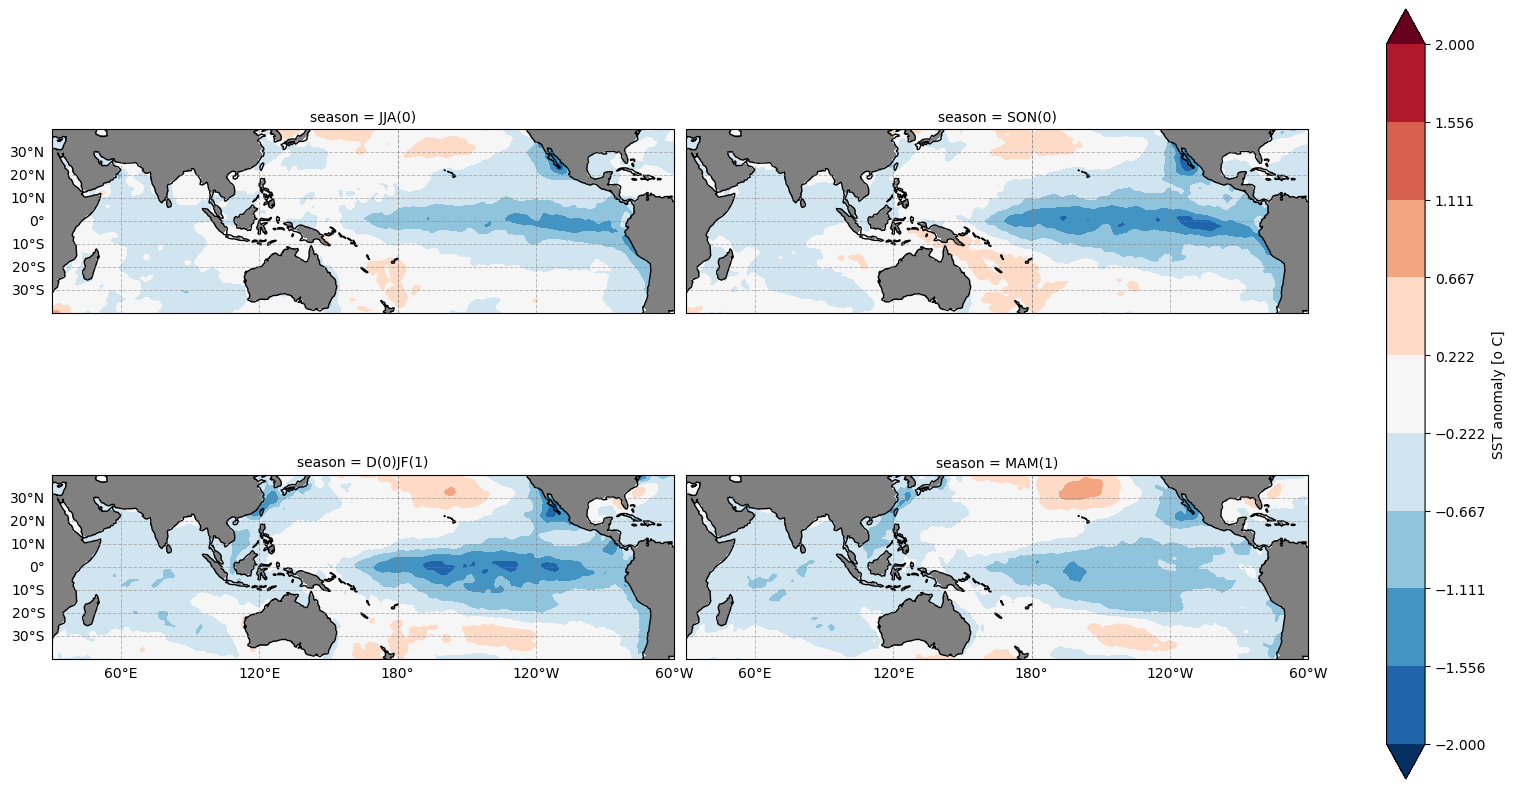

In [52]:
fg = LN3.plot.contourf(col="season", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

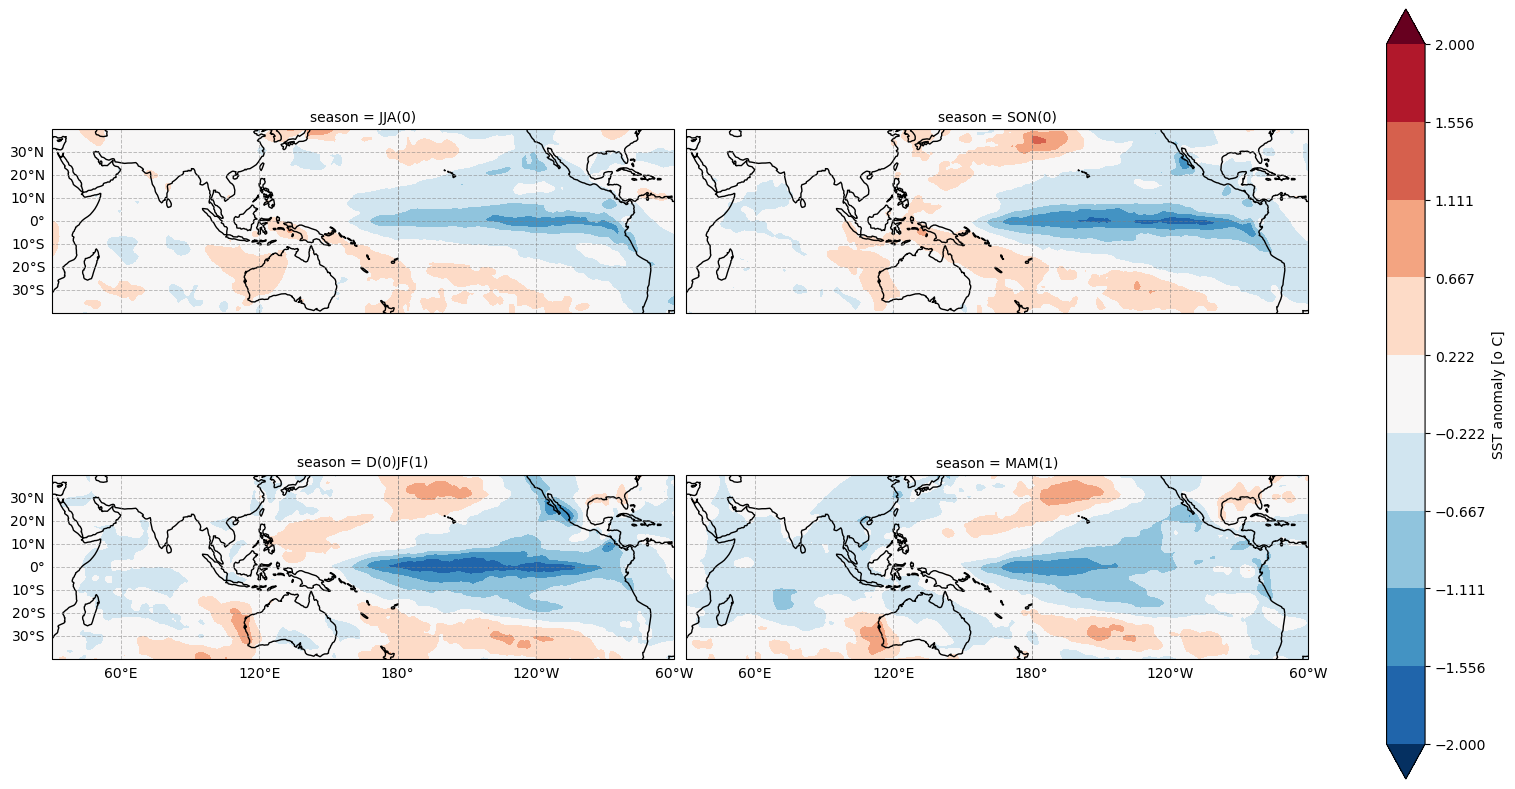

In [53]:
fg = LN3o.plot.contourf(col="season", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

In [54]:
EMOD1, EMOD2, LMOD1, LMOD2 = get_ENLN_times(Modoki, de_had, de_had_anom)

In [55]:
EMOD1e, EMOD2e, LMOD1e, LMOD2e = get_ENLN_times(Modoki, ersstv5, er_anom)

some error, probs year is no in timeseries


In [56]:
EMOD1o, EMOD2o, LMOD1o, LMOD2o = get_ENLN_times(Modoki, oisst, oi_anom)

In [57]:
EMOD3 = monthly_evo(EMOD1, EMOD2)
LMOD3 = monthly_evo(LMOD1, LMOD2)

In [58]:
EMOD3e = monthly_evo(EMOD1e, EMOD2e)
LMOD3e = monthly_evo(LMOD1e, LMOD2e)

In [59]:
EMOD3o = monthly_evo(EMOD1o, EMOD2o)
LMOD3o = monthly_evo(LMOD1o, LMOD2o)

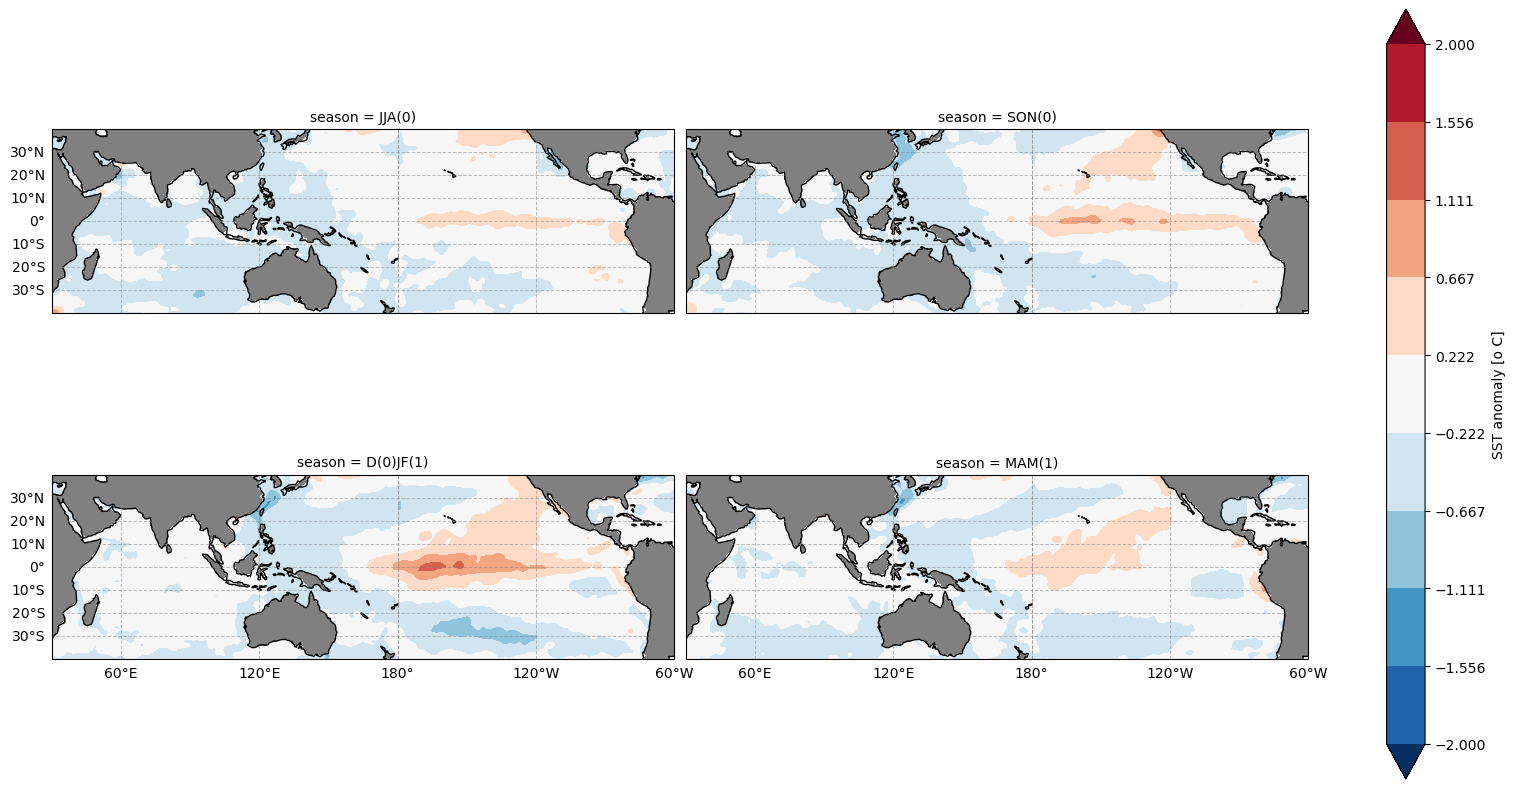

In [60]:
fg = EMOD3.plot.contourf(col="season", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False 

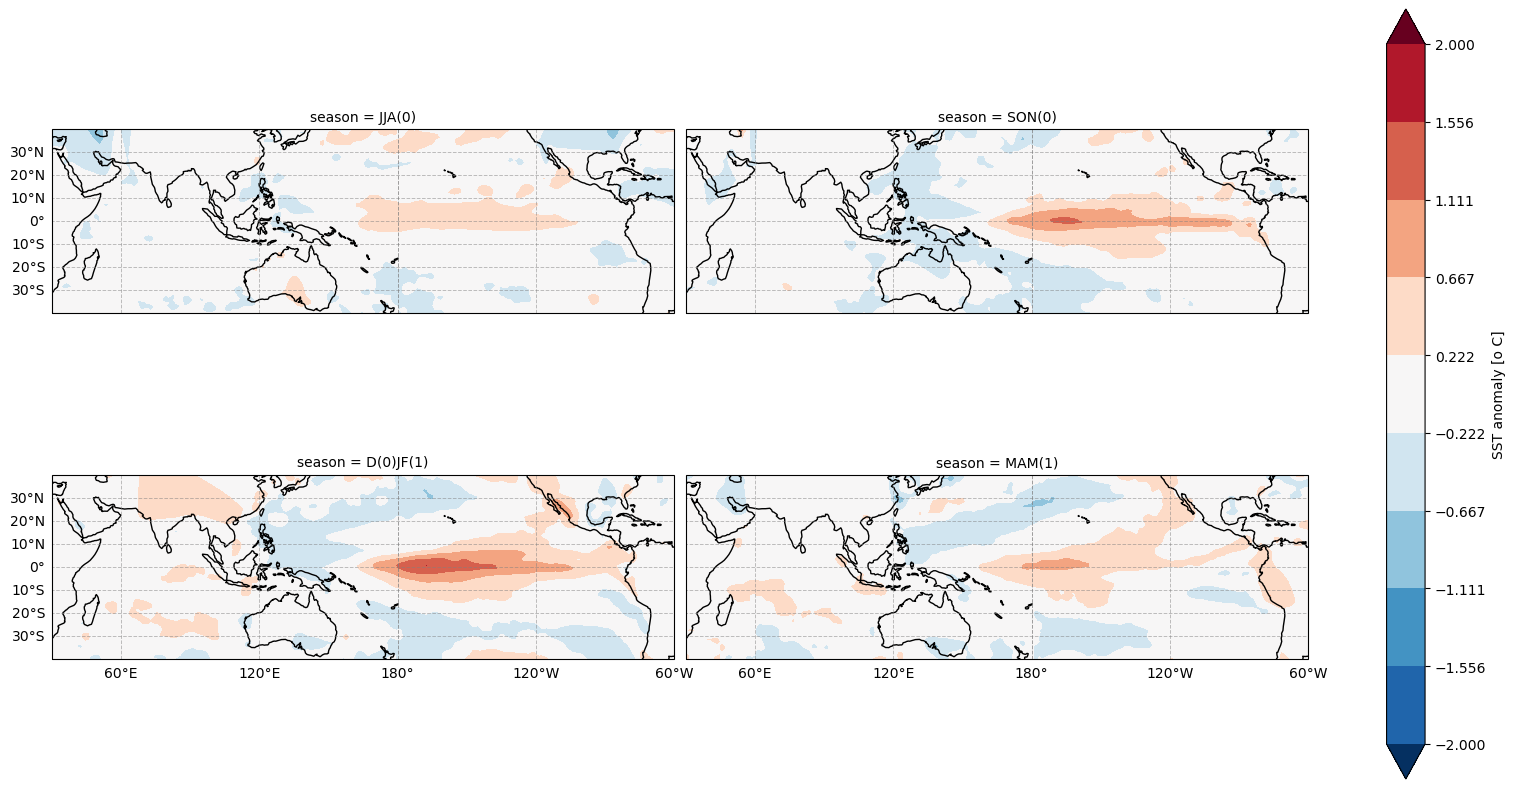

In [61]:
fg = EMOD3o.plot.contourf(col="season", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

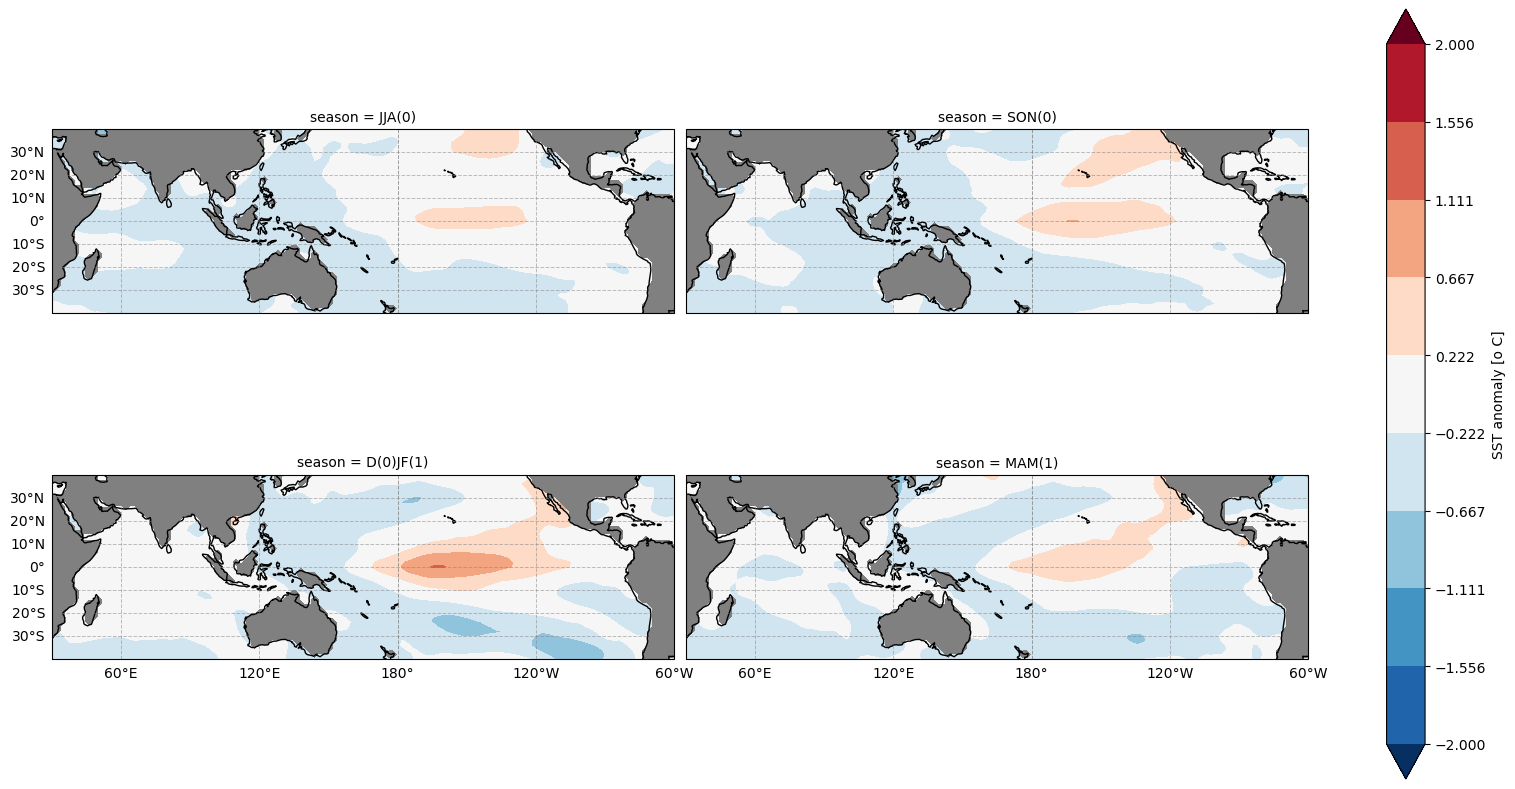

In [62]:
fg = EMOD3e.plot.contourf(col="season", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

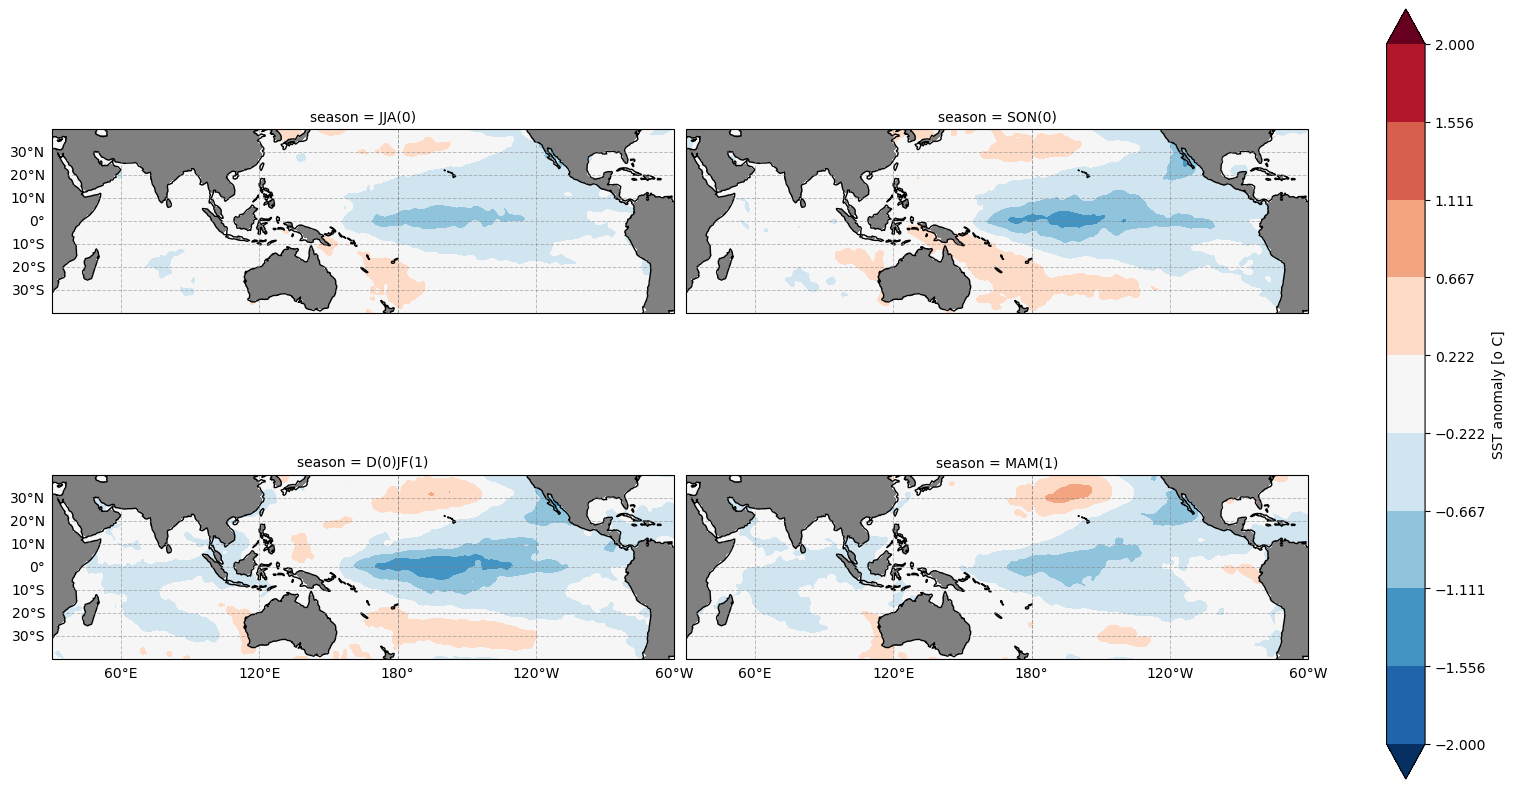

In [63]:
fg = LMOD3.plot.contourf(col="season", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

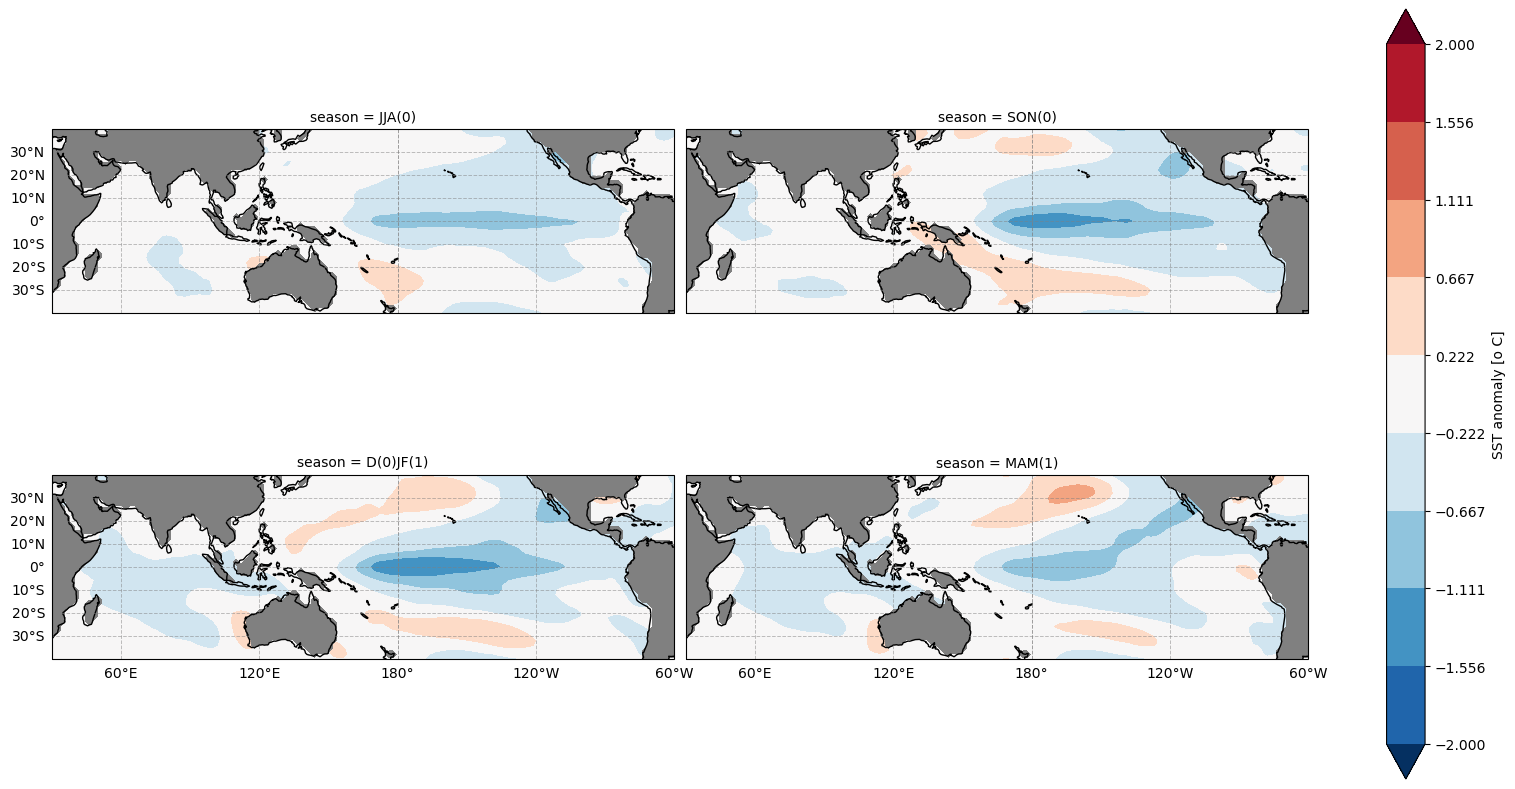

In [64]:
fg = LMOD3e.plot.contourf(col="season", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

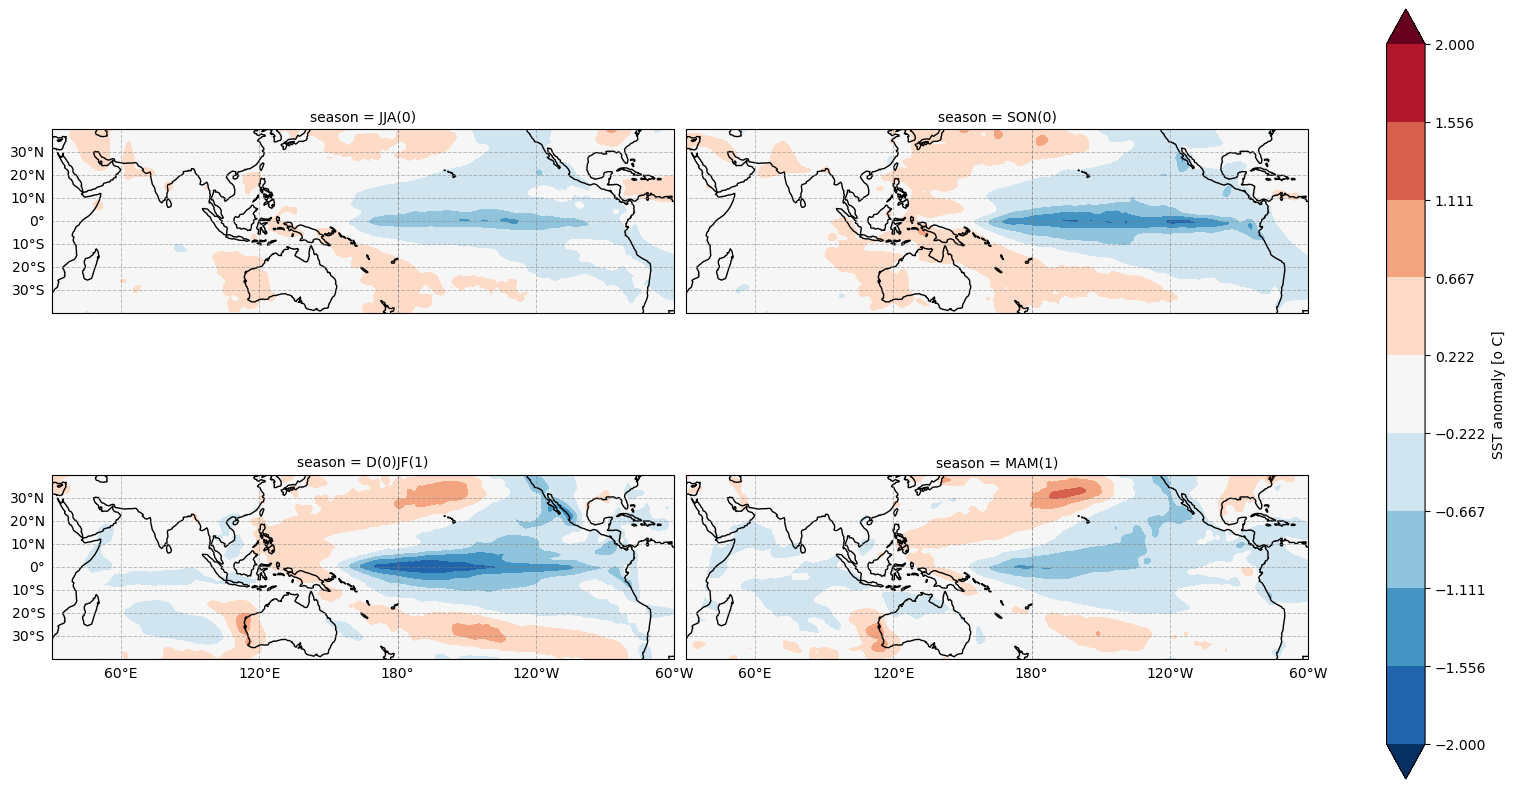

In [65]:
fg = LMOD3o.plot.contourf(col="season", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1]:
        gl.bottom_labels = False
    if i in [1,3]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

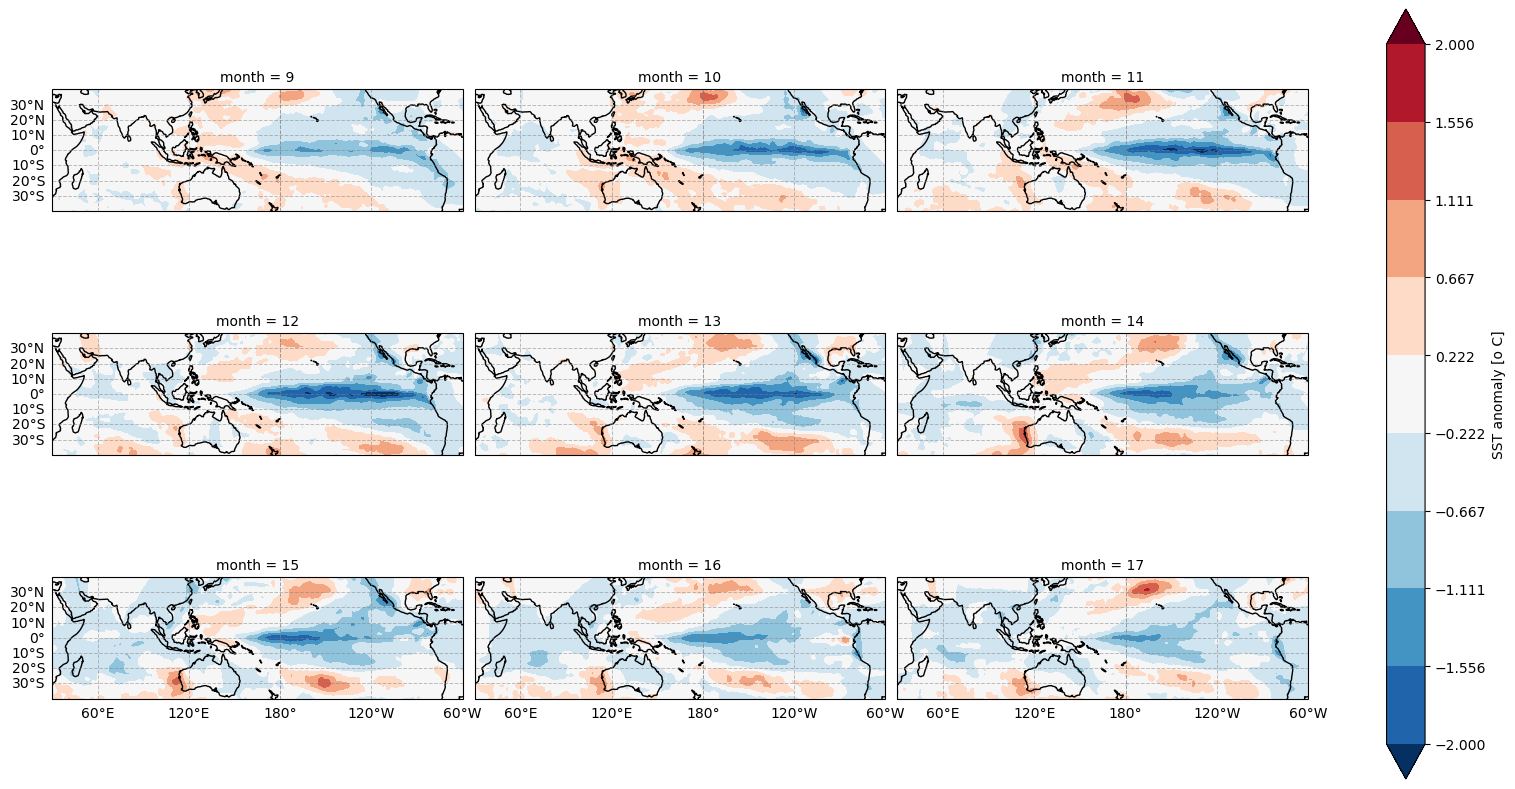

In [47]:
fg = LN3o.sel(month = slice(9,17)).plot.contourf(col="month", col_wrap = 3, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5]:
        gl.bottom_labels = False
    if i in [1,2,4,5,7,8]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

In [48]:
lat_limits = (-40, 40)
lon_limits = (-150, 120) 

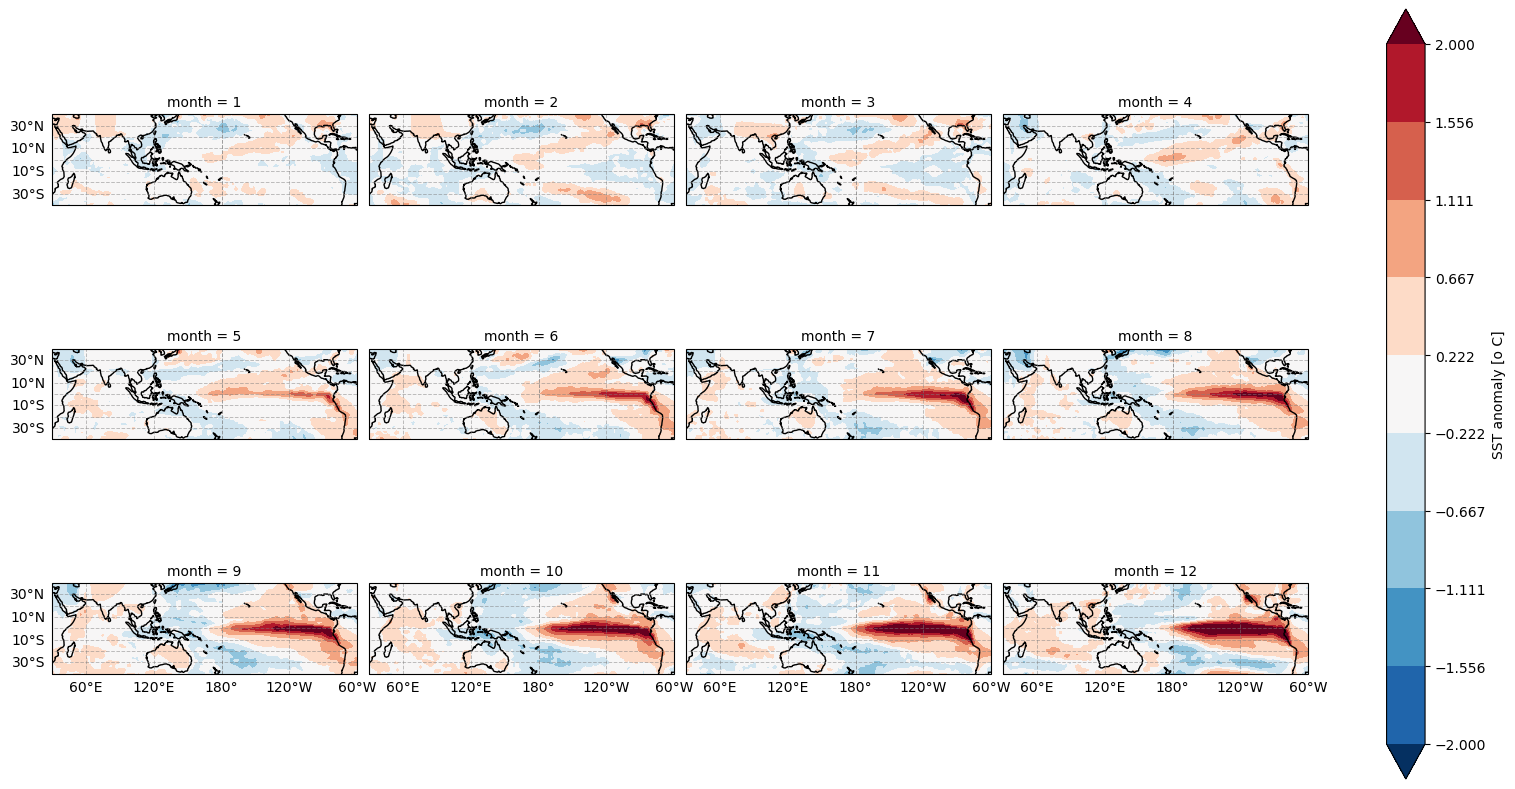

In [49]:
fg = EN31o.groupby("time.month").mean("time").plot.contourf(col="month", col_wrap = 4, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7]:
        gl.bottom_labels = False
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

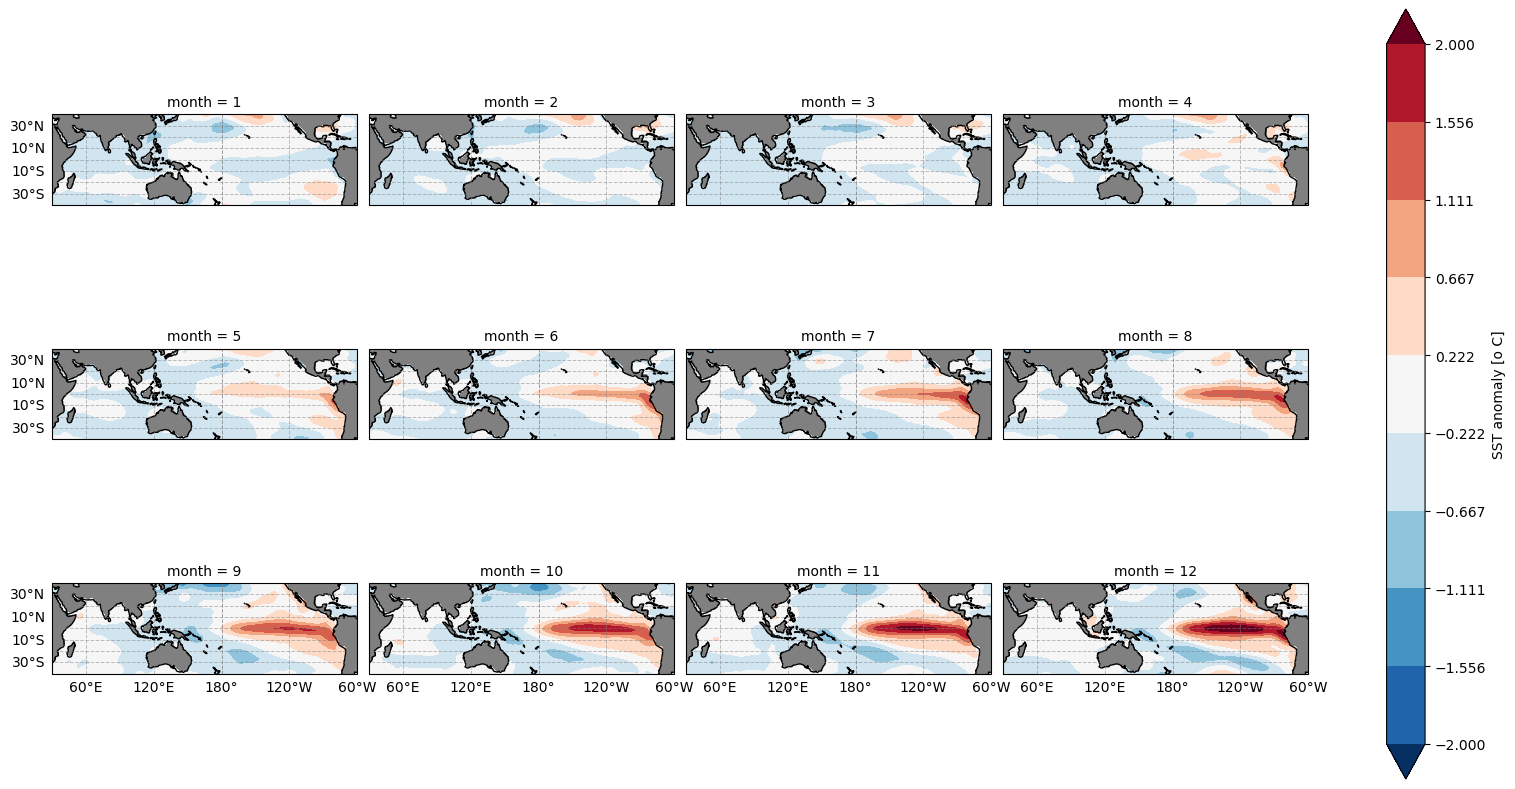

In [50]:
fg = EN31e.groupby("time.month").mean("time").plot.contourf(col="month", col_wrap = 4, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7]:
        gl.bottom_labels = False
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

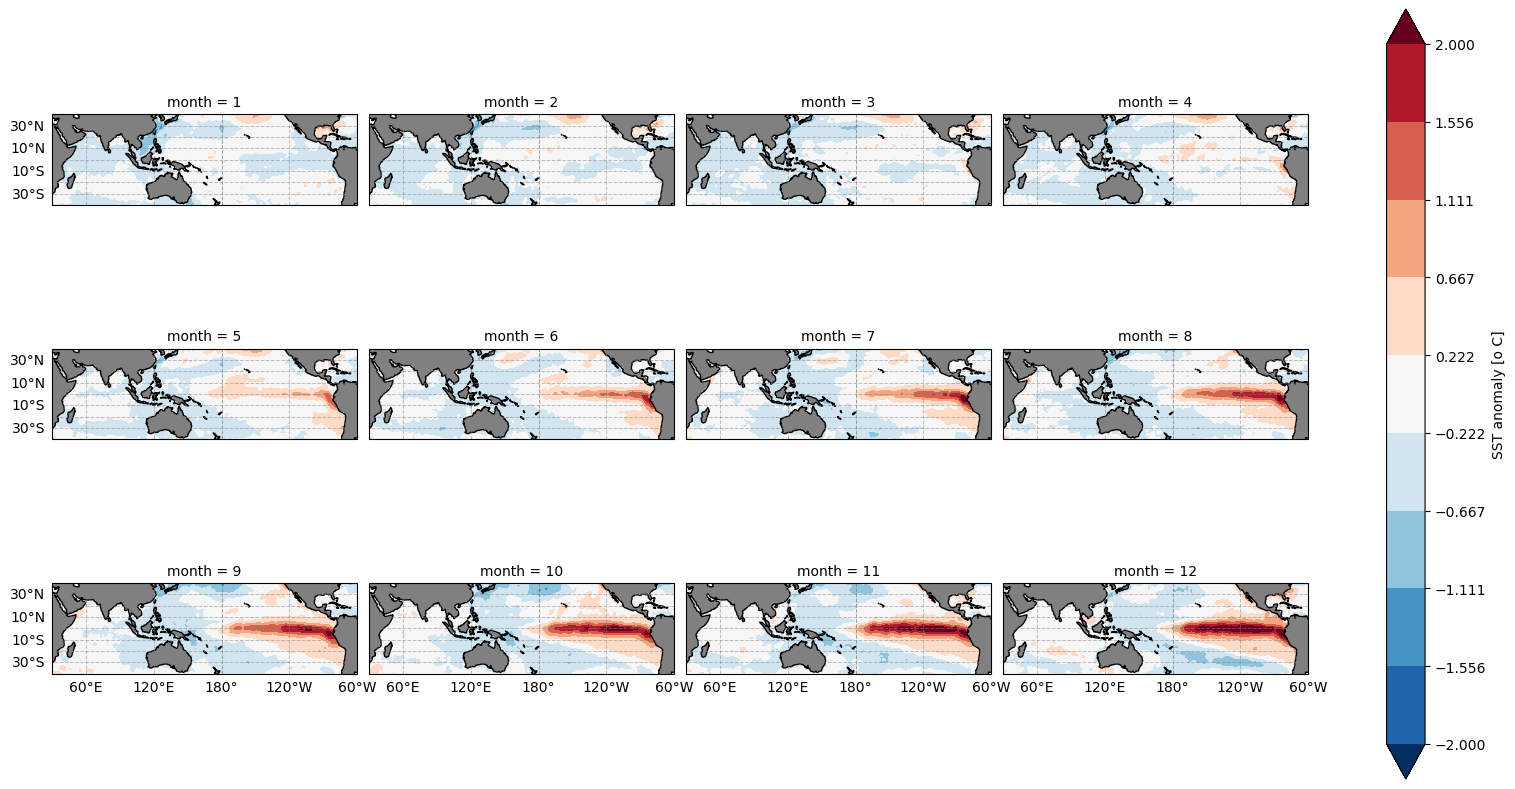

In [51]:
fg = EN31.groupby("time.month").mean("time").plot.contourf(col="month", col_wrap = 4, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7]:
        gl.bottom_labels = False
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

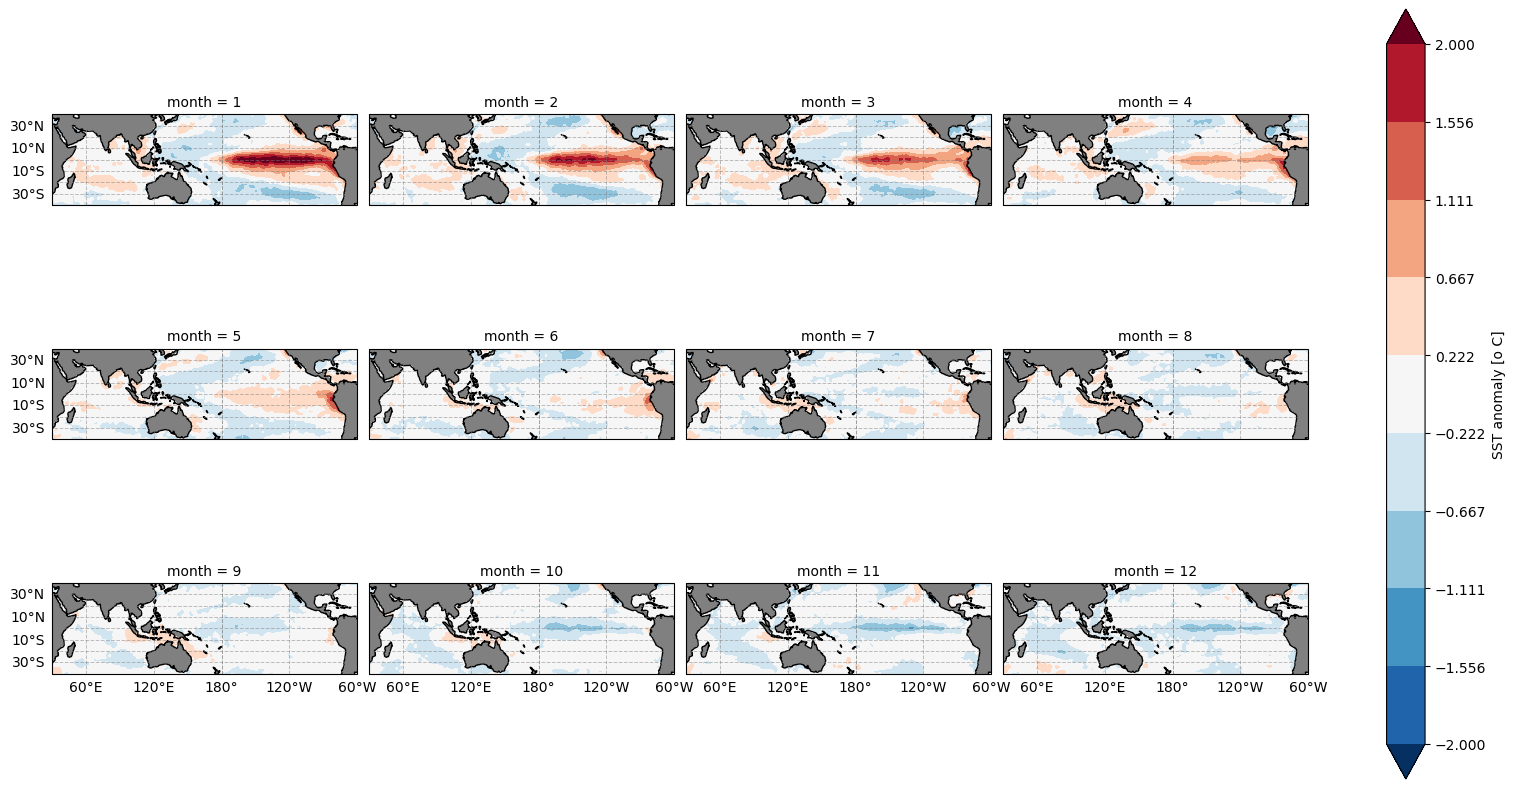

In [52]:
fg = EN32.groupby("time.month").mean("time").plot.contourf(col="month", col_wrap = 4, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7]:
        gl.bottom_labels = False
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

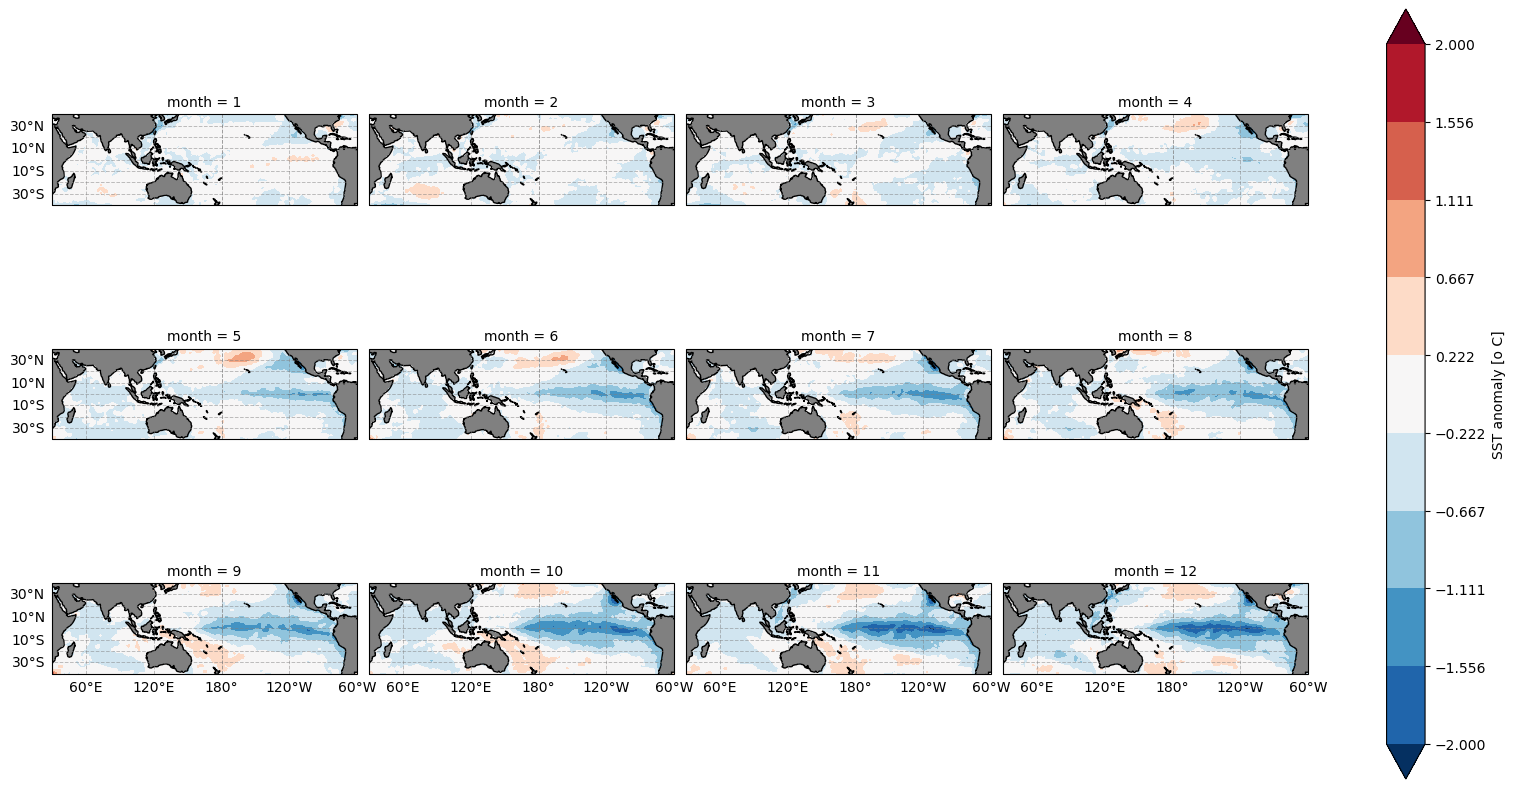

In [53]:
fg = LN31.groupby("time.month").mean("time").plot.contourf(col="month", col_wrap = 4, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7]:
        gl.bottom_labels = False
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

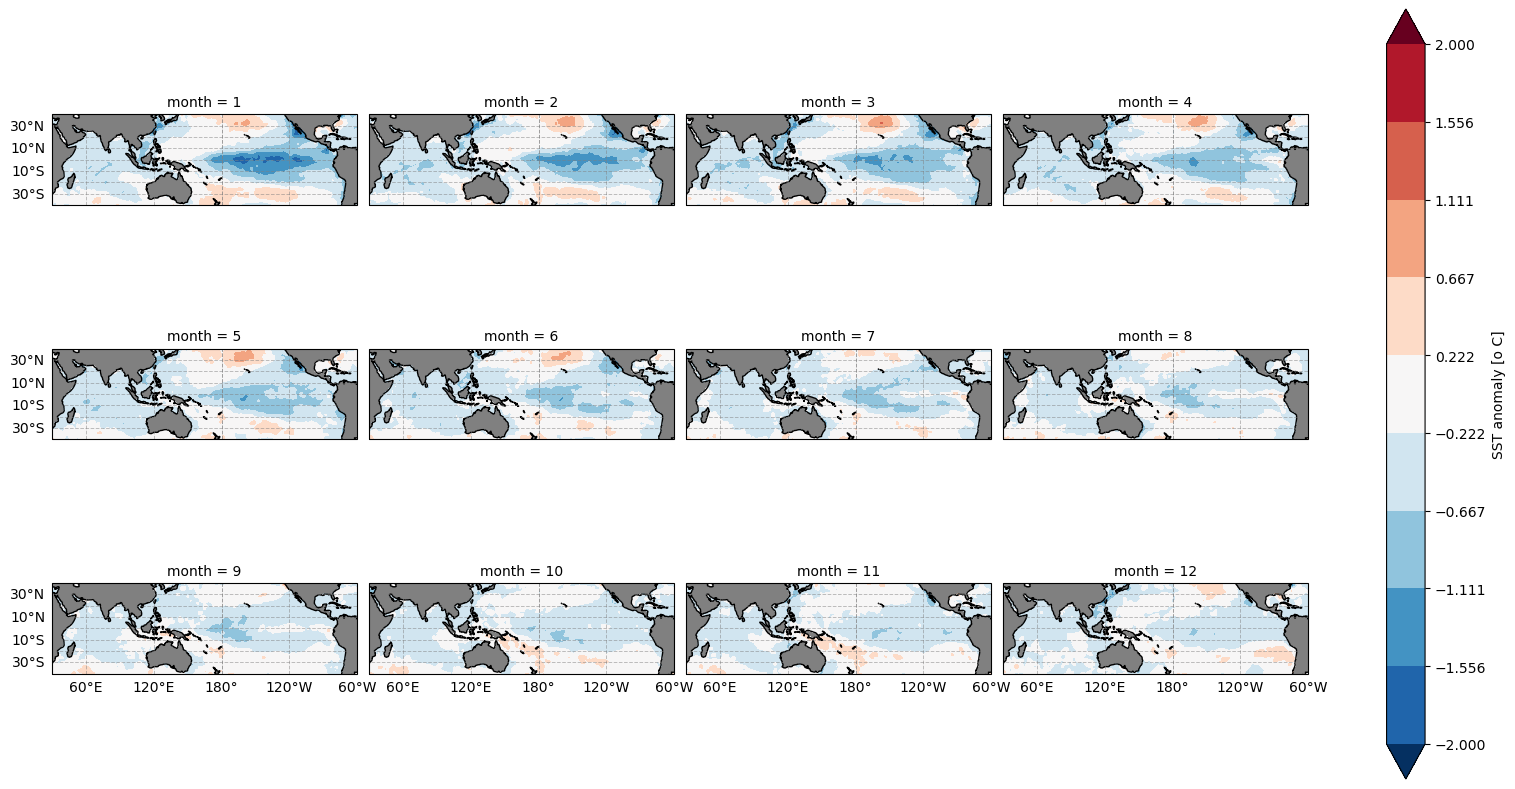

In [54]:
fg = LN32.groupby("time.month").mean("time").plot.contourf(col="month", col_wrap = 4, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7]:
        gl.bottom_labels = False
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

In [55]:
EMOD1, EMOD2, LMOD1, LMOD2 = get_ENLN_times(Modoki, de_had, de_had_anom)

In [56]:
EMOD1e, EMOD2e, LMOD1e, LMOD2e = get_ENLN_times(Modoki, ersstv5, er_anom)

some error, probs year is no in timeseries


In [57]:
EMOD1o, EMOD2o, LMOD1o, LMOD2o = get_ENLN_times(Modoki, oisst, oi_anom)

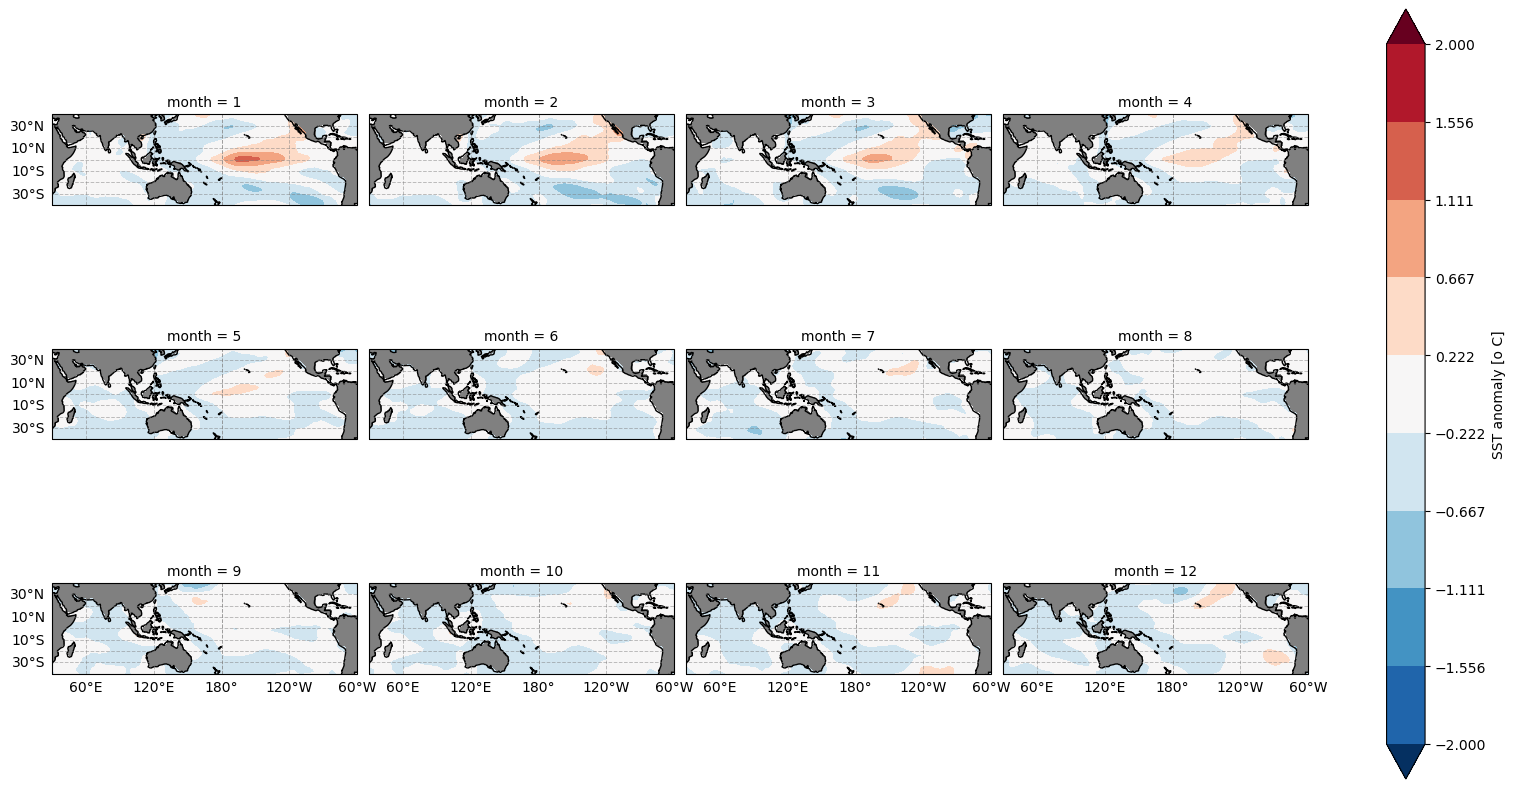

In [113]:
fg = EMOD2e.groupby("time.month").mean("time").plot.contourf(col="month", col_wrap = 4, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7]:
        gl.bottom_labels = False
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

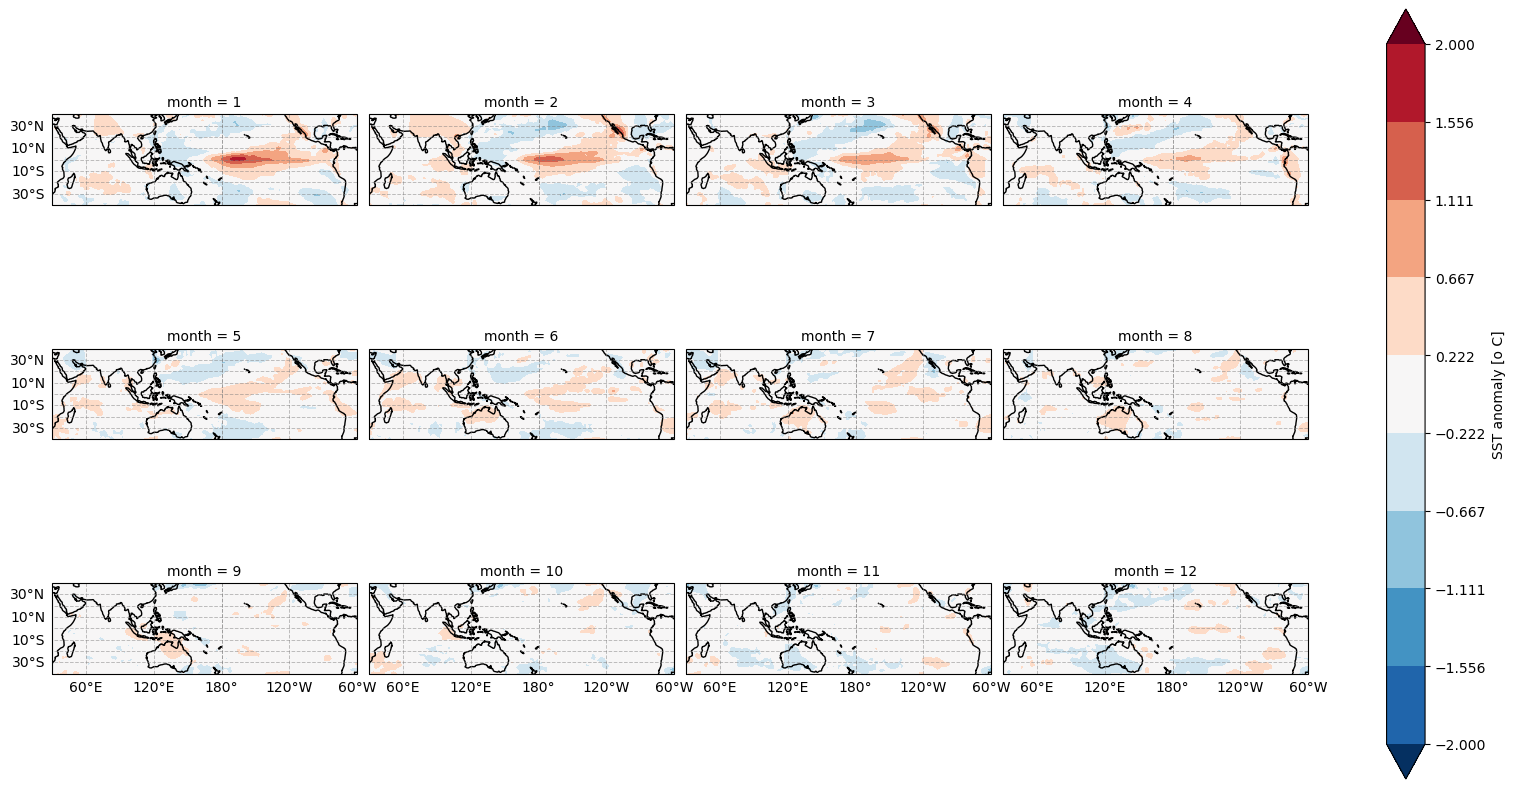

In [114]:
fg = EMOD2o.groupby("time.month").mean("time").plot.contourf(col="month", col_wrap = 4, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7]:
        gl.bottom_labels = False
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

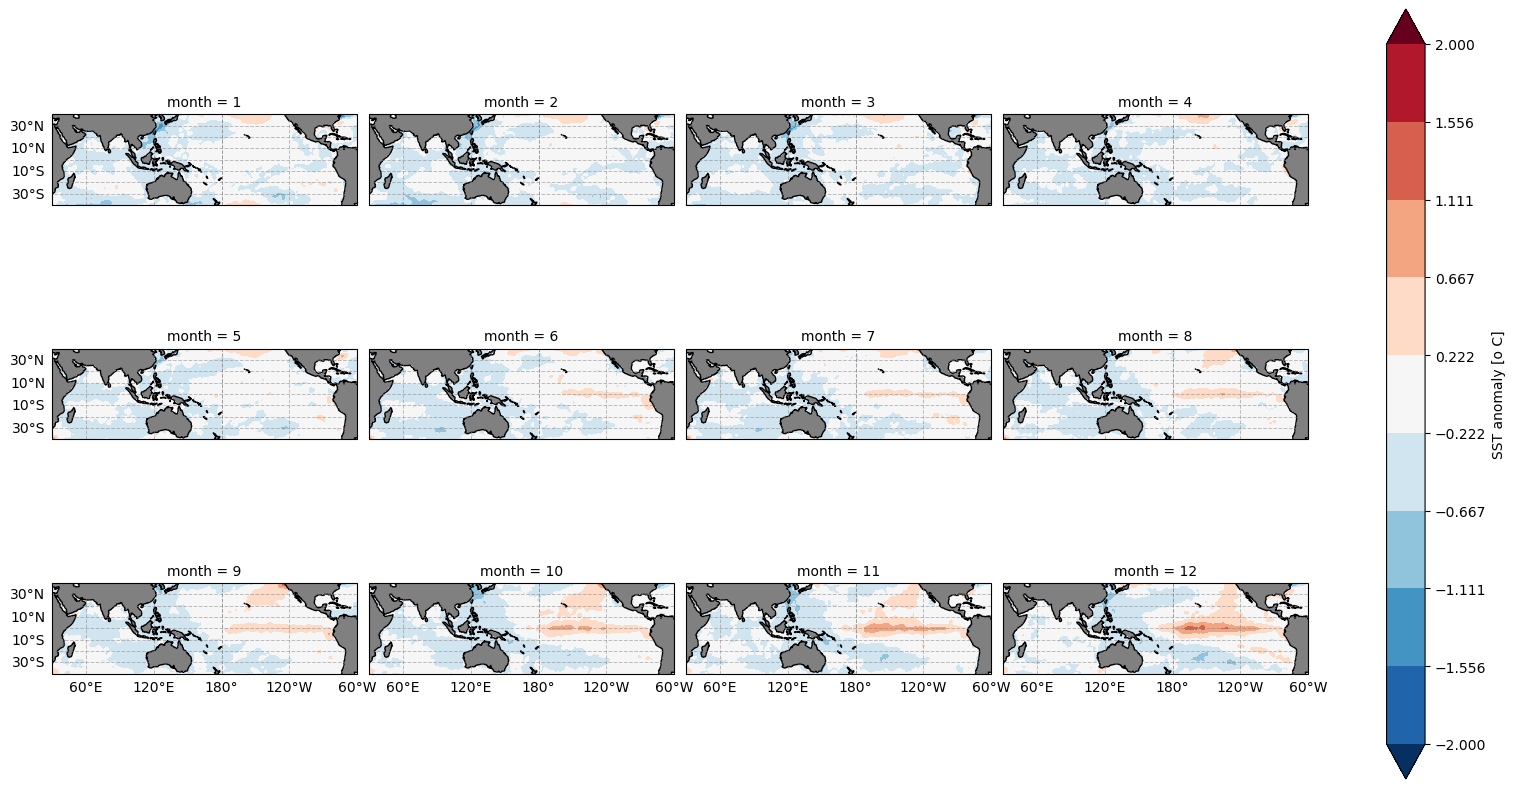

In [22]:
fg = EMOD1.groupby("time.month").mean("time").plot.contourf(col="month", col_wrap = 4, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7]:
        gl.bottom_labels = False
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

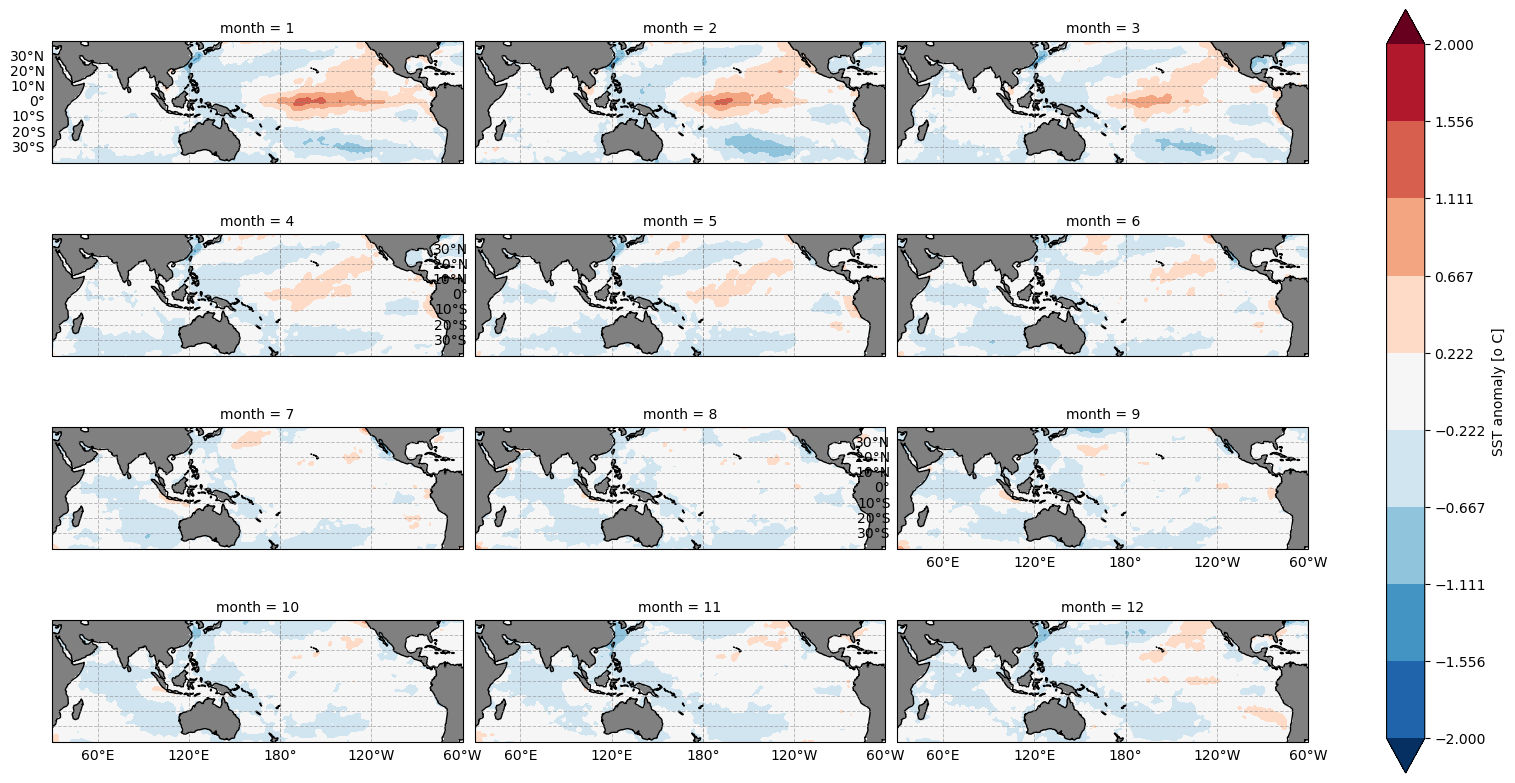

In [23]:
fg = EMOD2.groupby("time.month").mean("time").plot.contourf(col="month", col_wrap = 3, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7]:
        gl.bottom_labels = False
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

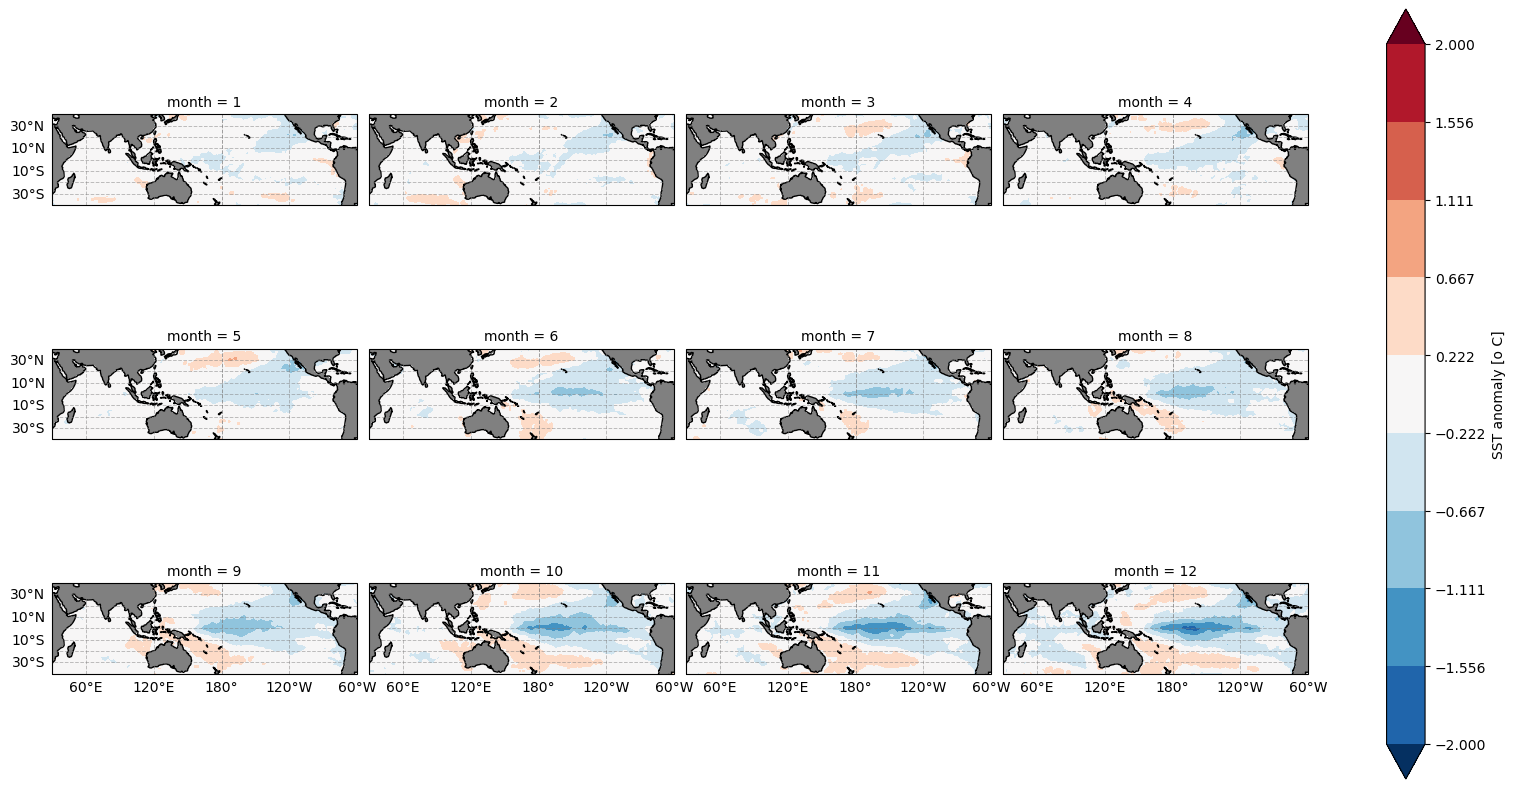

In [24]:
fg = LMOD1.groupby("time.month").mean("time").plot.contourf(col="month", col_wrap = 4, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7]:
        gl.bottom_labels = False
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

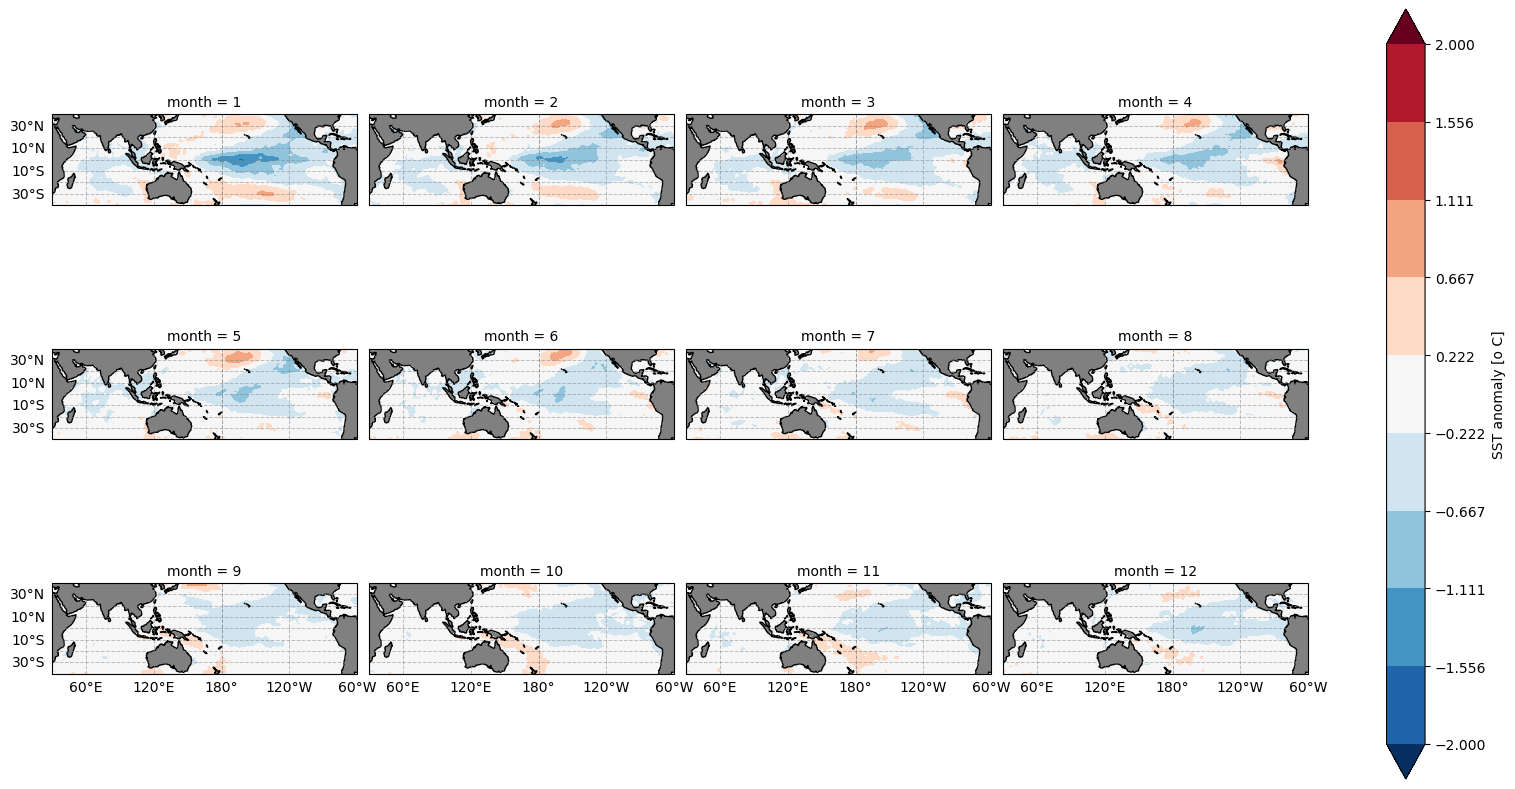

In [25]:
fg = LMOD2.groupby("time.month").mean("time").plot.contourf(col="month", col_wrap = 4, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7]:
        gl.bottom_labels = False
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

In [26]:
print(EN31.groupby('time.year').mean("time").year.values)

[1957 1965 1972 1982 1986 1991 1997 2009 2015]


In [27]:
print(EMOD1.groupby('time.year').mean("time").year.values)

[1957 1958 1965 1967 1968 1977 1979 1990 1991 1994 2004 2009 2014]


In [28]:
print(LN31.groupby('time.year').mean("time").year.values)

[1955 1967 1970 1973 1975 1984 1988 1999 2007 2010]


In [29]:
print(LMOD1.groupby('time.year').mean("time").year.values)

[1973 1975 1988 1997 1998 1999 2000 2007 2008 2010 2011]


In [30]:
eL.groupby("time.year").mean("time").year

NameError: name 'eL' is not defined

In [20]:
#time to go through years and get the SSTA composite for these years. 


In [85]:
ersstv5

<xarray.DataArray 'sst' (time: 840, latitude: 89, longitude: 180)>
array([[[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
...
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2019-12-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

Text(0.5, 1.0, 'HadISST Nino4 and Modoki indexes (season averaged each year)')

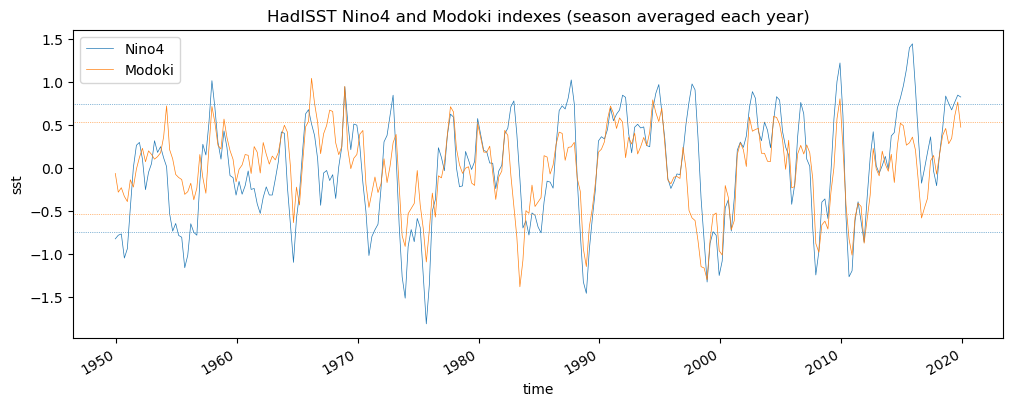

In [19]:
NINO4(hadsst1).resample(time='QS-DEC').mean(dim="time").plot(figsize = (12, 4),  lw= 0.5, label = "Nino4")
Modoki(hadsst1).resample(time='QS-DEC').mean(dim="time").plot(lw= 0.5, label = "Modoki")
plt.axhline(Modoki(de_had).groupby("time.season")["DJF"].std(), c = 'tab:orange', lw = 0.5, ls = ":")
plt.axhline(-1*Modoki(de_had).groupby("time.season")["DJF"].std(), c = 'tab:orange', lw = 0.5, ls = ":")
plt.axhline(NINO4(de_had).groupby("time.season")["DJF"].std(), c = 'tab:blue', lw = 0.5, ls = ":")
plt.axhline(-1*NINO4(de_had).groupby("time.season")["DJF"].std(), c = 'tab:blue', lw = 0.5, ls = ":")
plt.legend()
plt.title("HadISST Nino4 and Modoki indexes (season averaged each year)")

Text(0.5, 1.0, 'HadISST Nino3 and Modoki indexes (season averaged each year)')

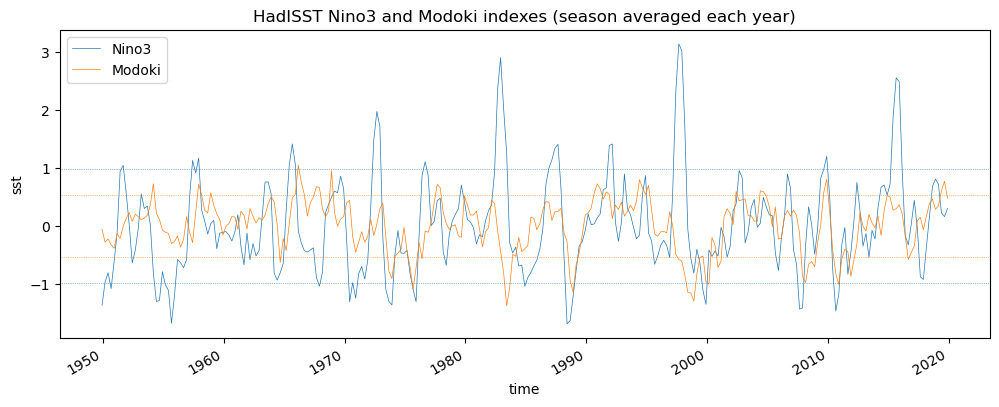

In [115]:
NINO3(hadsst1).resample(time='QS-DEC').mean(dim="time").plot(figsize = (12, 4),  lw= 0.5, label = "Nino3")
Modoki(hadsst1).resample(time='QS-DEC').mean(dim="time").plot(lw= 0.5, label = "Modoki")
plt.axhline(Modoki(de_had).groupby("time.season")["DJF"].std(), c = 'tab:orange', lw = 0.5, ls = ":")
plt.axhline(-1*Modoki(de_had).groupby("time.season")["DJF"].std(), c = 'tab:orange', lw = 0.5, ls = ":")
plt.axhline(NINO3(de_had).groupby("time.season")["DJF"].std(), c = 'tab:blue', lw = 0.5, ls = ":")
plt.axhline(-1*NINO3(de_had).groupby("time.season")["DJF"].std(), c = 'tab:blue', lw = 0.5, ls = ":")
plt.legend()
plt.title("HadISST Nino3 and Modoki indexes (season averaged each year)")

Text(0.5, 1.0, 'Nino3 index')

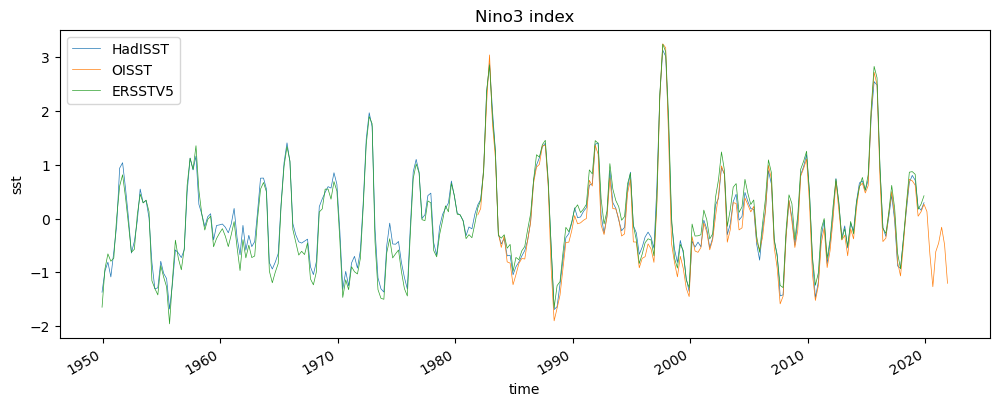

In [83]:
NINO3(hadsst1).resample(time='QS-DEC').mean(dim="time").plot(figsize = (12, 4),  lw= 0.5, label = "HadISST")
NINO3(oisst).resample(time='QS-DEC').mean(dim="time").plot(lw= 0.5, label = "OISST")
NINO3(ersstv5).resample(time='QS-DEC').mean(dim="time").plot(lw= 0.5, label = "ERSSTV5")
plt.legend()
plt.title("Nino3 index")

Text(0.5, 1.0, 'Modoki index')

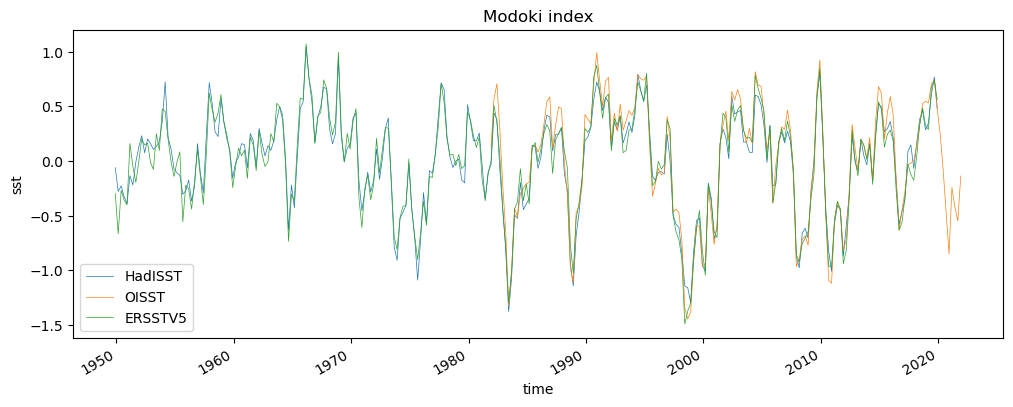

In [84]:
Modoki(hadsst1).resample(time='QS-DEC').mean(dim="time").plot(figsize = (12, 4),  lw= 0.5, label = "HadISST")
Modoki(oisst).resample(time='QS-DEC').mean(dim="time").plot(lw= 0.5, label = "OISST")
Modoki(ersstv5).resample(time='QS-DEC').mean(dim="time").plot(lw= 0.5, label = "ERSSTV5")
plt.legend()
plt.title("Modoki index")

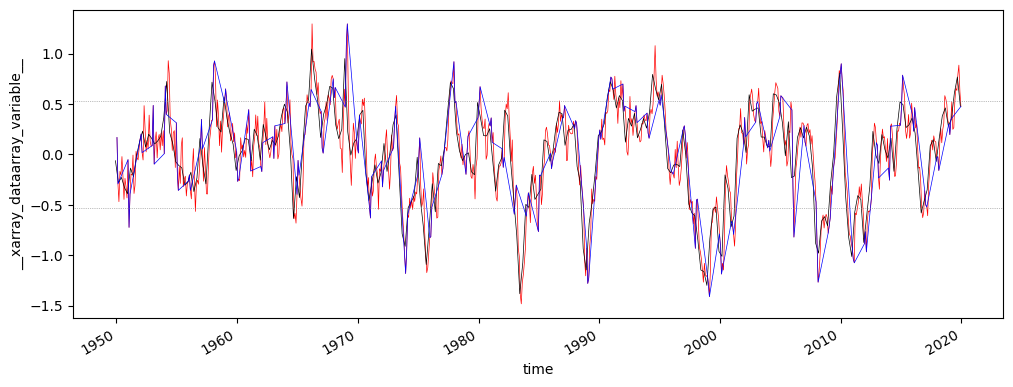

In [42]:
Modoki(de_had).plot(figsize = (12, 4), c= 'r', lw= 0.5)
Modoki(de_had).resample(time='QS-DEC').mean(dim="time").plot( c= 'k', lw= 0.5)
Modoki(de_had).groupby("time.season")["DJF"].plot(c= 'b', lw= 0.5)

plt.axhline(Modoki(de_had).groupby("time.season")["DJF"].std(), c = 'gray', lw = 0.5, ls = ":")
plt.axhline(-1*Modoki(de_had).groupby("time.season")["DJF"].std(), c = 'gray', lw = 0.5, ls = ":")

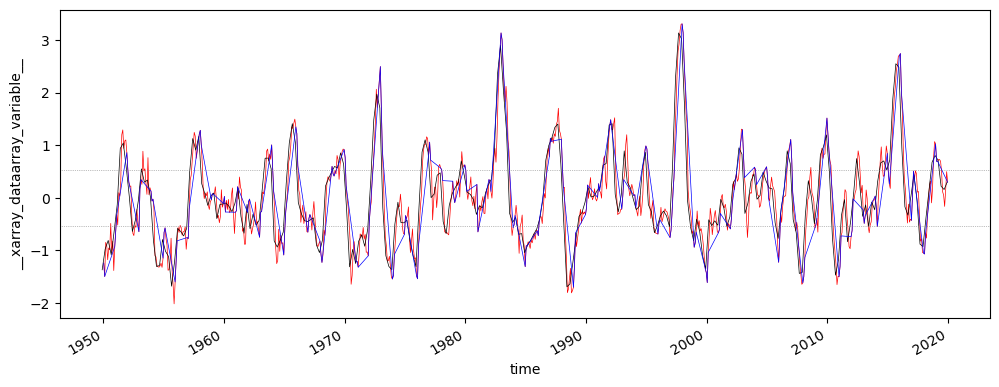

In [43]:
NINO3(de_had).plot(figsize = (12, 4), c= 'r', lw= 0.5)
NINO3(de_had).resample(time='QS-DEC').mean(dim="time").plot( c= 'k', lw= 0.5)
NINO3(de_had).groupby("time.season")["DJF"].plot(c= 'b', lw= 0.5)

plt.axhline(Modoki(de_had).groupby("time.season")["DJF"].std(), c = 'gray', lw = 0.5, ls = ":")
plt.axhline(-1*Modoki(de_had).groupby("time.season")["DJF"].std(), c = 'gray', lw = 0.5, ls = ":")

In [38]:
Modoki(de_had).groupby("time.season").mean("time")

<xarray.DataArray '__xarray_dataarray_variable__' (season: 4)>
array([2.27965794e-15, 2.21833134e-15, 2.35578752e-15, 2.18872539e-15])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [223]:
mask = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/sst_restore_mask_tropical_Pacific_Ocean_15S-15N_5degdampimg.nc", decode_times=False)

In [4]:
basins = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/basin_mask_20111103.nc", decode_times = False)

In [5]:
basins = basins.BASIN_MASK

In [6]:
mask = mask.restore_mask

In [7]:
PO = basins.where(basins == 3)

In [8]:
PO = xr.where(PO == 3, 1, 0)

In [9]:
PO = PO.rename({"ST_OCEAN1_1":"DEPTH1_1", "YT_OCEAN":"GRID_Y_T", "XT_OCEAN":"GRID_X_T"})

In [10]:
PO = PO.assign_coords({"DEPTH1_1":[0.0]})

In [11]:
PO2 = xr.concat([PO,PO,PO,PO,PO,PO,PO,PO,PO,PO,PO,PO], mask.TIME)

In [13]:
mask = mask.compute()

In [14]:
PO2 = PO2.compute()

In [15]:
new = mask+PO2

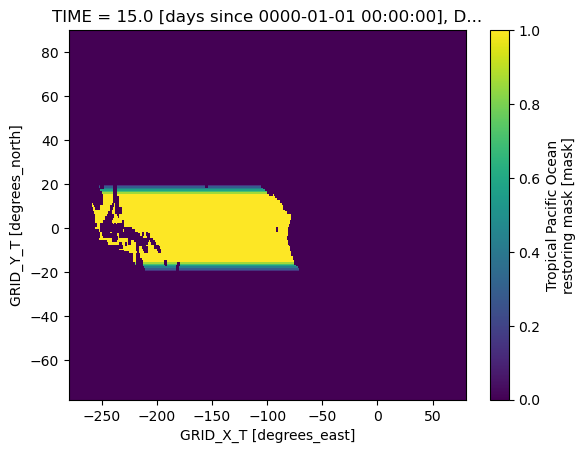

In [16]:
mask[0,0].plot()

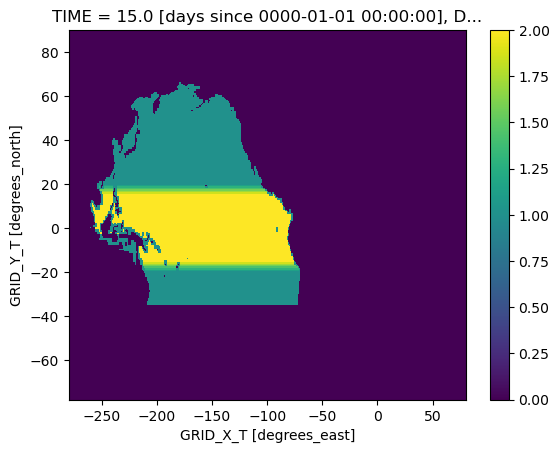

In [17]:
new[0,0].plot()

In [23]:
PO_30 = new.where(new.GRID_Y_T < 30, 0).where(new.GRID_Y_T > -30, 0)

In [28]:
PO_30_1 = xr.where(PO_30 >=1, 1, 0)

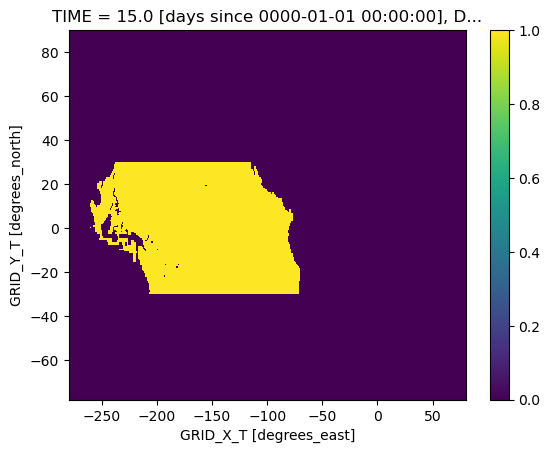

In [41]:
PO_30_1.where((PO_30_1.GRID_Y_T <30), 0)[0,0].plot()

In [43]:
mask = (PO_30_1['GRID_Y_T'] >= 25) & (PO_30_1['GRID_Y_T'] <= 30)

# Calculate tapering values based on latitude
latitudes = PO_30_1['GRID_Y_T'].values
taper_values = np.where(mask, 1 - ((latitudes - 25) / 5), 0)  # Linear taper from 1 to 0 in the specified range

# Apply the tapering values to the data
data_modified = PO_30_1 * taper_values[:, np.newaxis, np.newaxis]


In [65]:
latitude_values = PO_30_1.coords['GRID_Y_T']

# Create an array the same size as lat x lon with latitude values
# Repeat latitude values across lon dimension
latitude_array = xr.DataArray(latitude_values.data[:, None] * xr.ones_like(PO_30_1[0,0], dtype=bool),
                              dims=['GRID_Y_T', 'GRID_X_T'])

In [96]:
lower_limit = 25
upper_limit = 30

# Apply linear transformation to values between 25 and 30
masked_array = np.where(
    (latitude_array >= lower_limit) & (latitude_array <= upper_limit),
    1 - (latitude_array - lower_limit) / (upper_limit - lower_limit),
    latitude_array
)

# Create an xarray DataArray with the transformed values
transformed_latitude_array = xr.DataArray(masked_array, dims=['lat', 'lon'])


In [244]:
lower_limit = -30
upper_limit = -25
lowers = ((latitude_array - lower_limit) / (upper_limit - lower_limit))

lower_limit = 25
upper_limit = 30
uppers = (1-(latitude_array - lower_limit) / (upper_limit - lower_limit))

In [245]:
uppers = (uppers.where(uppers>0, 0).where(uppers<1,1)).where(lowers.GRID_Y_T>-25,0)

In [246]:
lowers = (lowers.where(lowers>0, 0).where(lowers<1,1)).where(lowers.GRID_Y_T<25,0)

In [247]:
latitude_mask = (lowers+uppers).where((lowers+uppers)<2, 1)

In [248]:
#add the time and depth dimesnion to latidue mask

In [249]:
latitude_mask = latitude_mask.expand_dims(dim = {"TIME":PO_30_1.TIME}, axis = 0).expand_dims(dim = {"DEPTH1_1":[0.0]}, axis = 1)

In [265]:
new_mask = latitude_mask.where(PO_30_1>0, 0)

In [266]:
new_mask = new_mask.assign_coords({"TIME":mask.TIME, "DEPTH1_1":mask.DEPTH1_1, "GRID_X_T":mask.GRID_X_T, "GRID_Y_T":mask.GRID_Y_T})

In [267]:
new_mask = new_mask.assign_attrs({"long_name": "Tropical Pacific Ocean restoring mask", "units": "mask", "valid_range": np.array([0.0, 1.0], dtype=np.float32)})
new_mask = new_mask.astype("float32")
new_mask = new_mask.to_dataset(name = 'restore_mask')
new_mask = new_mask.assign_attrs({"description": "Tropical Pacific Ocean restore mask 25S-25N plus 5deg damping to 30S-30N (1=restore, 0=no restore) for ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 19/12/23"})

In [268]:
new_mask

<xarray.Dataset>
Dimensions:       (DEPTH1_1: 1, TIME: 12, GRID_Y_T: 300, GRID_X_T: 360)
Coordinates:
  * DEPTH1_1      (DEPTH1_1) float64 0.0
  * TIME          (TIME) float64 15.0 44.0 73.5 104.0 ... 287.5 318.5 349.0
  * GRID_Y_T      (GRID_Y_T) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * GRID_X_T      (GRID_X_T) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
Data variables:
    restore_mask  (TIME, DEPTH1_1, GRID_Y_T, GRID_X_T) float32 0.0 0.0 ... 0.0
Attributes:
    description:  Tropical Pacific Ocean restore mask 25S-25N plus 5deg dampi...
    history:      Created 19/12/23

In [236]:
mask

<xarray.Dataset>
Dimensions:       (TIME: 12, DEPTH1_1: 1, GRID_Y_T: 300, GRID_X_T: 360)
Coordinates:
  * TIME          (TIME) float64 15.0 44.0 73.5 104.0 ... 287.5 318.5 349.0
  * DEPTH1_1      (DEPTH1_1) float64 0.0
  * GRID_Y_T      (GRID_Y_T) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * GRID_X_T      (GRID_X_T) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
Data variables:
    restore_mask  (TIME, DEPTH1_1, GRID_Y_T, GRID_X_T) float32 ...
Attributes:
    description:  Tropical Pacific Ocean restore mask 15S-15N plus 5deg dampi...
    history:      Created 17/12/22

In [242]:
new_mask

<xarray.Dataset>
Dimensions:       (DEPTH1_1: 1, TIME: 12, GRID_Y_T: 300, GRID_X_T: 360)
Coordinates:
  * DEPTH1_1      (DEPTH1_1) float64 0.0
  * TIME          (TIME) float64 15.0 44.0 73.5 104.0 ... 287.5 318.5 349.0
  * GRID_Y_T      (GRID_Y_T) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * GRID_X_T      (GRID_X_T) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
Data variables:
    restore_mask  (TIME, DEPTH1_1, GRID_Y_T, GRID_X_T) float64 0.0 0.0 ... 0.0

In [198]:
PO_30_1[:,0]

<xarray.DataArray (TIME: 12, GRID_Y_T: 300, GRID_X_T: 360)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * TIME      (TIME) float64 15.0 44.0 73.5 104.0 ... 257.0 287.5 318.5 349.0
    DEPTH1_1  float64 0.0
  * GRID_Y_T  (GRID_Y_T) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * GRID_X_T  (GRID_X_T) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5

In [82]:
data_flattened

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [ nan,  nan,  nan, ..., -1.8, -1.8, -1.8],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)

In [81]:
data_flattened = hadsst1.values.reshape(hadsst1.values.shape[0], -1)

# Perform SVD
U, s, V = np.linalg.svd(data_flattened, full_matrices=False)

# Calculate EOFs (spatial patterns) and PCs (principal components)
# Reshape back to original dimensions
num_eofs = 3  # Select number of EOFs (change as needed)
eofs = xr.DataArray(U[:, :num_eofs].reshape((-1,) + hadsst1.shape[1:]),
                    coords=[('eof', np.arange(num_eofs)), *hadsst1.coords])
pcs = xr.DataArray(np.dot(data_flattened, V[:num_eofs, :]),
                   coords=[('time', ds.time), ('eof', np.arange(num_eofs))])


LinAlgError: SVD did not converge